# Table of Contents

1. Introduction
2. Dataset
3. Data Cleaning for analysis
4. Exploratory Data Analysis

- **Part I**: Is it worth it to be a superhost in Buenos Aires? What about being verified?
- **Part II**: What are the prices in different neighbourhoods?
- **Part III**: What attributes of a listing correlate with price?
    - Data Preprocessing
    - Assesing Multicollinearity
    - Modeling



## 1. Introduction 

Airbnb is an online platform that connects people who want to rent out their homes with people who are looking for accommodations in that locale.
Setting the right price can be challenging for new hosts, and it's fundamental to find the sweet spot between occupancy and price. 

Buenos Aires Airbnb data pertaining to February 2021 was used to answer the following **three questions**:
- Is it worth it to be a superhost and/or being verified?
- What are the prices in different neighbourhoods?
- What attributes of a listing correlate with price?

## 2. The Dataset

The dataset used for this project comes from [Insideairbnb.com](http://insideairbnb.com/index.html), an independent, non-commercial set of tools and data that allows you to explore how Airbnb is being used in cities around the world. The data behind the Inside Airbnb site is sourced from publicly available information from the Airbnb site. It is available below under a [Creative Commons CC0 1.0 Universal (CC0 1.0) "Public Domain Dedication"](https://creativecommons.org/publicdomain/zero/1.0/) license.

In [ ]:
# all necessary imports 

!pip install geopandas
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import math
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from shapely.ops import unary_union
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
from scipy.stats import kruskal

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import scipy
from scipy.cluster import hierarchy as hc

In [ ]:
!pip3 freeze > requirements.txt

## 3. Data cleaning for analysis

In [ ]:
# pd.set_option('display.max_rows', 20)

In [ ]:
raw_data = pd.read_csv('sample_data/detailed_listings.csv')

print("Raw data shape:", raw_data.shape)

Raw data shape: (20243, 74)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data = raw_data.copy()

In [ ]:
data.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6283,https://www.airbnb.com/rooms/6283,20210223160926,2021-02-24,Casa Al Sur,<b>The space</b><br />This stunning studio apa...,NaN,https://a0.muscache.com/pictures/444657/4b4203...,13310,https://www.airbnb.com/users/show/13310,Pamela,2009-04-13,"New York, New York, United States",I'm from Argentina but live in New York.,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/13310/profile...,https://a0.muscache.com/im/users/13310/profile...,Balvanera,1.00,1.00,"['email', 'phone', 'reviews', 'kba']",t,t,NaN,Balvanera,nan,-34.60,-58.41,Entire apartment,Entire home/apt,2,nan,1 bath,nan,1.00,"[""Long term stays allowed"", ""Dryer"", ""Gym"", ""A...","$4,473.00",3,30,3.00,3.00,30.00,30.00,3.00,30.00,nan,t,30,60,90,365,2021-02-24,1,0,0,2011-01-31,2011-01-31,80.00,10.00,8.00,10.00,10.00,8.00,8.00,NaN,f,1,1,0,0,0.01
1,11508,https://www.airbnb.com/rooms/11508,20210223160926,2021-02-24,Amazing Luxurious Apt-Palermo Soho,<b>The space</b><br />LUXURIOUS NEW APT: 1 BDR...,AREA: PALERMO SOHO<br /><br />Minutes walking ...,https://a0.muscache.com/pictures/19357696/b1de...,42762,https://www.airbnb.com/users/show/42762,Candela,2009-10-01,"New York, New York, United States",-,NaN,NaN,100%,t,https://a0.muscache.com/im/users/42762/profile...,https://a0.muscache.com/im/users/42762/profile...,Palermo,1.00,1.00,"['email', 'phone', 'reviews', 'kba']",t,t,"Buenos Aires, Capital Federal, Argentina",Palermo,nan,-34.58,-58.42,Entire condominium,Entire home/apt,2,nan,1 bath,1.00,1.00,"[""Microwave"", ""Stove"", ""Kitchen"", ""Elevator"", ...","$5,368.00",2,1125,2.00,2.00,1125.00,1125.00,2.00,1125.00,nan,t,0,22,52,327,2021-02-24,26,0,0,2012-07-02,2019-11-28,95.00,10.00,10.00,10.00,10.00,10.00,10.00,NaN,f,1,1,0,0,0.25


### Missing values

In [ ]:
# columns with missing values in order
some_nulls = data.columns[data.isnull().mean()!= 0]
data[some_nulls].isnull().mean().sort_values(ascending=False)

bathrooms                      1.00
calendar_updated               1.00
neighbourhood_group_cleansed   1.00
license                        1.00
host_about                     0.42
host_acceptance_rate           0.42
host_response_time             0.40
host_response_rate             0.40
neighborhood_overview          0.37
neighbourhood                  0.37
review_scores_value            0.32
review_scores_cleanliness      0.32
review_scores_location         0.32
review_scores_checkin          0.32
review_scores_accuracy         0.32
review_scores_communication    0.32
review_scores_rating           0.32
reviews_per_month              0.31
last_review                    0.31
first_review                   0.31
host_neighbourhood             0.15
bedrooms                       0.15
description                    0.04
beds                           0.01
host_location                  0.00
bathrooms_text                 0.00
host_name                      0.00
host_since                  

We will drop columns with 100% of missing values, as well as those that are not useful for the analysis since they are not related to the problem. We will also set id as our index (this can be helpful for future analysis in order to use the information from the reviews for each listing)

**Obs:** host_id will be kept for analysis and then it will be dropped.

In [ ]:
to_drop = ['bathrooms', 'calendar_updated', 'neighbourhood_group_cleansed', 
           'license', 'listing_url', 'scrape_id', 'last_scraped', 'name', 
           'picture_url', 'host_url', 'host_name', 'host_thumbnail_url', 
           'host_picture_url', 'host_neighbourhood', 'calendar_last_scraped']

data = data.drop(to_drop, axis=1)

In [ ]:
data = data.set_index('id')

In [ ]:
data.shape

(20243, 58)

### Features exploration and cleaning

Let's explore and clean features one by one, starting for the ones that pandas interpreted as categorical:

In [ ]:
cat_data = data.select_dtypes(include='object')
num_data = data.select_dtypes(include= ['int64', 'float64'])

In [ ]:
cat_data.shape, num_data.shape

((20243, 23), (20243, 35))

In [ ]:
cat_data.head(2)

,description,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,price,has_availability,first_review,last_review,instant_bookable
id,,,,,,,,,,,,,,,,,,,,,,,
6283,<b>The space</b><br />This stunning studio apa...,NaN,2009-04-13,"New York, New York, United States",I'm from Argentina but live in New York.,NaN,NaN,NaN,f,"['email', 'phone', 'reviews', 'kba']",t,t,NaN,Balvanera,Entire apartment,Entire home/apt,1 bath,"[""Long term stays allowed"", ""Dryer"", ""Gym"", ""A...","$4,473.00",t,2011-01-31,2011-01-31,f
11508,<b>The space</b><br />LUXURIOUS NEW APT: 1 BDR...,AREA: PALERMO SOHO<br /><br />Minutes walking ...,2009-10-01,"New York, New York, United States",-,NaN,NaN,100%,t,"['email', 'phone', 'reviews', 'kba']",t,t,"Buenos Aires, Capital Federal, Argentina",Palermo,Entire condominium,Entire home/apt,1 bath,"[""Microwave"", ""Stove"", ""Kitchen"", ""Elevator"", ...","$5,368.00",t,2012-07-02,2019-11-28,f


**description**, **neighborhood_overview**

Since we are not using NLP for now, we will drop these text columns. Description will be kept to disambiguate another category (property_type) and then it will be dropped.

In [ ]:
data.drop(['neighborhood_overview'], axis=1, inplace=True)

**host_since**

This is the date that the host has joined Airbnb. We will transform it into the number of years the host has been in the platform.

In [ ]:
data.host_since

id
6283        2009-04-13
11508       2009-10-01
12463       2009-10-28
13095       2009-11-03
13096       2009-11-03
               ...    
48284207    2018-04-26
48284447    2015-04-06
48284693    2015-01-22
48286831    2015-08-18
48292318    2018-10-21
Name: host_since, Length: 20243, dtype: object

In [ ]:
# transform into datetime
data.host_since = pd.to_datetime(data.host_since) 

In [ ]:
data['years_since_joined'] = 2021 - data['host_since'].dt.year

In [ ]:
# checking it's alright
data[['host_since', 'years_since_joined']]

,host_since,years_since_joined
id,,
6283,2009-04-13,12.00
11508,2009-10-01,12.00
12463,2009-10-28,12.00
13095,2009-11-03,12.00
13096,2009-11-03,12.00
...,...,...
48284207,2018-04-26,3.00
48284447,2015-04-06,6.00
48284693,2015-01-22,6.00


In [ ]:
data.drop('host_since', axis=1, inplace=True)

**host_location**

This feature has too many unique values indicating where the host is located and many are just the same information written differently. We will write a function to clean it and grouping values into 3 levels:
- "Buenos Aires"
- "Other province"
- "Other country"

In [ ]:
# Number of unique values
data.host_location.nunique()

901

In [ ]:
# Exploring unique values
data[data.host_location.notnull()].host_location.unique().tolist();

In [ ]:
# First grouping iteration to check which ones are miscategorized
provinces = ['argentina', 'santa fe', 'la plata', 'córdoba', 'cordoba', 
             'neuquén', 'neuquen', 'patagonia', 'rio negro', 'san luis', 
             'la pampa', 'tucuman', 'tucumán', 'tierra del fuego', 
             'santiago del estero', 'santa cruz', 'san juan', 'salta', 
             'misiones', 'la rioja', 'jujuy', 'formosa', 'entre rios', 
             'entre ríos', 'corrientes', 'chubut', 'chaco', 'catamarca']
buenos_aires = []
other_province = []
other_country = []

for item in data[data.host_location.notnull()].host_location.unique():

  if ("buenos aires" or "capital federal" or "autonomous" or "autónoma" \
      or "CABA") in item.lower():
    buenos_aires.append(item)
  
  elif any(p in item.lower() for p in provinces):
    other_province.append(item)
    if "argentina" not in item.lower(): # some provinces' names are too common
      print("Check if this one is 'other_province':", item)

  else:
    other_country.append(item)
    if "argentina" in item.lower():
      print("Warning - This item is going to 'other_country':", item)

Check if this one is 'other_province': Santa Cruz, California, United States
Check if this one is 'other_province': Santa Cruz de Tenerife, Canarias, Spain
Check if this one is 'other_province': San Luis Potosi, San Luis Potosi, Mexico
Check if this one is 'other_province': Santa Cruz de Tenerife, Canary Islands, Spain
Check if this one is 'other_province': Santa Cruz de la Sierra, Santa Cruz, Bolivia
Check if this one is 'other_province': Río Grande, Tierra del Fuego


In [ ]:
# Checking if lentghs are equal
locations = data[data.host_location.notnull()].host_location.unique()
len(locations), len(buenos_aires) + len(other_country) + len(other_province)

(901, 901)

In [ ]:
# Looking inside the lists
buenos_aires;
other_country;
other_province;

In [ ]:
# Cleaning exceptions so they can be categorized properly
data.host_location = data.host_location.replace({
    """Hi! Currently I don't live in Buenos Aires, and together with my familiy 
    I rent my apartment.""" : "Other place",
    "AR": "Argentina",
    "Buenos Airers": "Buenos Aires",
    "rio de laplata": "Buenos Aires",
    "Santa Cruz, California, United States": "United States",
    "Santa Cruz de Tenerife, Canarias, Spain": "Spain",
    "San Luis Potosi, San Luis Potosi, Mexico": "Mexico",
    "Santa Cruz de Tenerife, Canary Islands, Spain": "Spain",
    "Santa Cruz de la Sierra, Santa Cruz, Bolivia": "Bolivia"})

In [ ]:
def clean_locations(row):
  """ Cleans column host_location in dataframe """

  provinces = ['argentina', 'santa fe', 'la plata', 'córdoba', 'cordoba', 
               'neuquén', 'neuquen', 'patagonia', 'rio negro', 'san luis', 
               'la pampa', 'tucuman', 'tucumán', 'tierra del fuego', 
               'santiago del estero', 'santa cruz', 'san juan', 'salta', 
               'misiones', 'la rioja', 'jujuy', 'formosa', 'entre rios', 
               'entre ríos', 'corrientes', 'chubut', 'chaco', 'catamarca']
             
  if row is np.nan: 
    return np.nan

  elif ("buenos aires" or "capital federal" or "autonomous" or "autónoma" \
        or "CABA") in row.lower(): 
    return "buenos aires"

  elif any(p in row.lower() for p in provinces):
    return "other province"

  else:
    return "other country"

In [ ]:
data.host_location = data.host_location.apply(clean_locations)

In [ ]:
data.host_location.unique()

array(['other country', 'buenos aires', 'other province', nan],
      dtype=object)

In [ ]:
data.host_location.mode()

0    buenos aires
dtype: object

**host_about**

We will not analyse the text inside this feature, but since there is 42% of values missing, we will create another column that indicates if this information is missing or not for each listing, to explore if having that information on the profile is something that matters.

In [ ]:
data.host_about.isnull().mean()

0.421429629995554

In [ ]:
# Cleaning exceptions
data.host_about.unique().tolist();
data.host_about = data.host_about.replace(['............', '...', '-'], np.nan)

In [ ]:
data['host_about_info'] = np.where(data.host_about.notnull(), 1, 0)

In [ ]:
# We'll drop original feature
data.drop('host_about', axis=1, inplace=True)

**host_response_time**

We have almost 40% missing values for this feature. In this case, it means this information was unknown for a potential guest, so that's the value we will give them

In [ ]:
data.host_response_time.isnull().mean()

0.39821172751074446

In [ ]:
data.host_response_time = data.host_response_time.fillna('unknown')

In [ ]:
data.host_response_time.unique()

array(['unknown', 'within an hour', 'within a few hours', 'within a day',
       'a few days or more'], dtype=object)

**host_response_rate**

In the same way we did it for host_response_time, we will rename missing values for this feature as "unknown". We will also create bins to group percentages in a more meaningful way.

In [ ]:
# let's transform strings into numbers
data.host_response_rate = [int(num[:-1]) if num is not np.nan else np.nan \
                           for num in data.host_response_rate]

In [ ]:
# create bins
data.host_response_rate = pd.cut(data.host_response_rate, 
                                   bins=[0, 80, 99, 100], 
                                   labels=['<80%', '80-99%', '100%'], 
                                   include_lowest=True)

In [ ]:
# and replace missing values with "unknown"
data.host_response_rate = data.host_response_rate.replace({np.nan: 'unknown'})

In [ ]:
data.host_response_rate.value_counts()

100%       8227
unknown    8061
<80%       2531
80-99%     1424
Name: host_response_rate, dtype: int64

**host_acceptance_rate**

The treatment for this feature is same as for host_response_rate

In [ ]:
data.host_acceptance_rate.isnull().mean()

0.4178728449340513

In [ ]:
data.host_acceptance_rate.value_counts();

In [ ]:
# transform strings into numbers
data.host_acceptance_rate = [int(num[:-1]) if num is not np.nan else np.nan \
                             for num in data.host_acceptance_rate]

In [ ]:
# create bins
data.host_acceptance_rate = pd.cut(data.host_acceptance_rate, 
                                   bins=[0, 80, 99, 100], 
                                   labels=['<80%', '80-99%', '100%'], 
                                   include_lowest=True)

In [ ]:
# and replace missing values with "unknown"
data.host_acceptance_rate = data.host_acceptance_rate.replace({np.nan: "unknown"})

In [ ]:
data.host_acceptance_rate.value_counts()

unknown    8459
100%       6474
<80%       2661
80-99%     2649
Name: host_acceptance_rate, dtype: int64

**host_is_superhost, host_verifications, host_identity_verified, host_has_profile_pic**

There are 7 rows that are missing values for many host-related features. We will drop them.


In [ ]:
print(data.host_is_superhost.isnull().sum(), \
      "missing values for host_is_superhost")
print(data[data.host_verifications=="None"].host_verifications.count(), \
      "'None' for host_verifications")
print(data.host_identity_verified.isnull().sum(), \
      "missing values for host_identity_verified")
print(data.host_has_profile_pic.isnull().sum(), \
      "missing values for host_has_profile_pic")

7 missing values for host_is_superhost
7 'None' for host_verifications
7 missing values for host_identity_verified
7 missing values for host_has_profile_pic


In [ ]:
data[data.host_is_superhost.isnull()][['host_is_superhost', 
                                       'host_verifications',
                                       'host_identity_verified', 
                                       'host_has_profile_pic']]

,host_is_superhost,host_verifications,host_identity_verified,host_has_profile_pic
id,,,,
20482168,NaN,None,NaN,NaN
23494076,NaN,None,NaN,NaN
23901883,NaN,None,NaN,NaN
27808922,NaN,None,NaN,NaN
28276399,NaN,None,NaN,NaN
34182798,NaN,None,NaN,NaN
40024308,NaN,None,NaN,NaN


In [ ]:
idx_to_drop = data[data.host_is_superhost.isnull()][['host_is_superhost', 
                                                     'host_verifications', 
                                                     'host_identity_verified', 
                                                     'host_has_profile_pic']].index

In [ ]:
data.drop(idx_to_drop, axis=0, inplace=True)

**host_is_superhost**: We will convert true and false strings into 1s and 0s

In [ ]:
data.host_is_superhost = data.host_is_superhost.replace({'t': 1, 'f': 0})

In [ ]:
data.host_is_superhost.value_counts()

0    14474
1     5762
Name: host_is_superhost, dtype: int64

**host_verifications**: this feature is quite redundant with host_identity_verified so we will keep the latter.

In [ ]:
data.drop('host_verifications', axis=1, inplace=True)

**host_identity_verified**: We will convert true and false strings into 1s and 0s

In [ ]:
data.host_identity_verified = data.host_identity_verified.replace({'t': 1, 
                                                                   'f': 0})

**host_has_profile_pic**

This feature has no variability since 99.77% of the values belong to just one level. It will be dropped.

In [ ]:
data.host_has_profile_pic.value_counts()

t    20190
f       46
Name: host_has_profile_pic, dtype: int64

In [ ]:
data[data.host_has_profile_pic == 't'].host_has_profile_pic.count() \
/ data.shape[0] * 100

99.77268234829018

In [ ]:
data.drop('host_has_profile_pic', axis=1, inplace=True)

The original **neighbourhood** feature will be dropped and  **neighbourhood_cleansed** will be renamed as "neighbourhood" since it's the same information but already cleaned.

In [ ]:
data.drop('neighbourhood', axis=1, inplace=True)
data.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

**property_type**

There are too many unique levels for this feature and some have only one or few values. We will group them in 3 categories: Apartment, House and Other lodging (where we will put things like hotel, hostel, bed and breakfast, guest suite, etc)

In [ ]:
data.property_type.isnull().any()

False

In [ ]:
data.property_type.unique().tolist();

In [ ]:
data.property_type.nunique()

69

In [ ]:
# First grouping to see if everything falls in the right place

house_like = ['house', 'townhouse', 'villa', 'casa', 'cabin', 'chalet', 'in-law', 
              'cottage']
apartment_like = ['apartment', 'loft', 'condominium', 'guestsuite', 'guest suite',
                  'floor', 'pension']
house = []
apartment = []
other = []

for item in data.property_type.unique().tolist():

  if any(h in item.lower() for h in house_like):
    house.append(item)
  elif any(a in item.lower() for a in apartment_like):
    apartment.append(item)
  else:
    other.append(item)
    print(item.lower(), "is going to 'other'")
  

private room in bed and breakfast is going to 'other'
entire home/apt is going to 'other'
room in aparthotel is going to 'other'
camper/rv is going to 'other'
car is going to 'other'
shared room in hostel is going to 'other'
private room is going to 'other'
room in bed and breakfast is going to 'other'
room in hostel is going to 'other'
entire place is going to 'other'
shared room in bed and breakfast is going to 'other'
room in boutique hotel is going to 'other'
private room in hostel is going to 'other'
room in hotel is going to 'other'
entire resort is going to 'other'
private room in farm stay is going to 'other'
shared room is going to 'other'
entire bed and breakfast is going to 'other'
boat is going to 'other'
private room in castle is going to 'other'
private room in boat is going to 'other'
private room in dorm is going to 'other'
campsite is going to 'other'
shared room in boutique hotel is going to 'other'


Let's check ambiguous cases like "Entire place", "Private Room", "Shared room" and "Entire home/apt".

In [ ]:
# For "Entire place", they all refer to apartments

data[data.property_type=="Entire place"].description.tolist()

['Great appartment in a great location on Santa Fe Avenue in Recoleta, two blocks away from Alto Palermo Shopping, one block from the next subway station, a sure ticket for visiting all best places in Buenos Aires. The ideal place for two people.<br /><br /><b>The space</b><br />Perfect for two people in a queen size bed, with a couch for a third party. All the comfort in a noiseless ambiance.  An open-air patio enlarges the premises.<br /><br /><b>Guest access</b><br />24 hours surveillance.<br /><br /><b>Other things to note</b><br />Very quiet.',
 'Excelente departamento studio, totalmente equipado, ubicado a 1 cuadra del Hospital Italiano. Muy proximo a Subte A y Subte B.<br /><br /><b>The space</b><br />El departamento cuenta con una cama matrimonial y otra cama de una plaza con carrito que sale debajo de la cama matrimonial, si gusta podemos colocarle un catre aparte con cama de una plaza o utiliza la cama con carrito que le describí. El dpto. esta totalmente equipado, tiene aire

In [ ]:
# For "Private room", it depends. We will disambiguate it using "description"
data[data.property_type=="Private room"].description.tolist()

[nan,
 '<b>The space</b><br />Habitación matrimonial con baño privado en hostel, ubicado en pleno barrio de San Telmo, con servicio de Internet wifi, ropa de cama y toallas. El lugar tiene cocina para los huéspedes, donde se pueden preparar comidas, sala de estar con confortables sillones y televisión para los ratos de descanso. <br /><br />Muy buena ubicación, en cercanía de universidades, lugares de atracción turística, restaurantes, bares y la urbanización de puerto madero, con acceso a todos los medios de transportes, para un cómodo recorrido por la ciudad. A  metros del Hostel esta Puerto madero, lugar de singular belleza y ofertas gastronómicas de primer nivel. Buena ubicación con acceso a todos los medios de transporte que recorren la ciudad.<br /><br />Nuestros huéspedes contaran con asesoramiento turístico para el mejor desarrollo de su estadía, un ambiente agradable y una esmerada atención de sus dueños. <br />Ofrecemos una esmerada atención para el disfrute de su estadía.',


In [ ]:
# For "Shared room", they all refer to apartments 
# (except the last one which we don't know)
data[data.property_type=="Shared room"].description.tolist()

['Ubicado en uno de los mejores  barrios de Capital Federal, muy cerca a todas las líneas de transporte público, edificio nuevo con piscina y ascensor, monoambiente totalmente equipado y amoblado, muy cómodo para unos días de visita a esta hermosa ciudad.<br /><br /><b>The space</b><br />Pueden hacer uso de la piscina, cocina, de todos los utensilios de la cocina, secador de cabello y planchita de cabello.<br /><br /><b>Guest access</b><br />Piscina<br /><br /><b>Other things to note</b><br />Pueden sentirse como en su propia casa, de la misma forma cuidar de este espacio como que fuese suyo.',
 'Mi departamento es chico pero yo soy re divertida :) Tengo dos camas tipo cucheta de una plaza. (una arriba de la otra) <br />Si es una pareja tal vez no estén cómodos pero para pasar una noche sirve!!! <br />Para una madre y una hija o dos amigas creo que esta bien. Vivo sola con mi gato . Puedo ayudarles asesoramiento para que conozcan la ciudad.<br /><br /><b>The space</b><br />Mi alojamien

In [ ]:
# For "Entire home/apt", it depends. We will disambiguate it using "description"
data[data.property_type=="Entire home/apt"].description.tolist()

['<b>The space</b><br />I offer a big and ancient house in Villa Lia, 18 kms away from San Antonio de Areco. <br />San Antonio de Areco is a very famous rural town, visited by thousands of tourists every weekend. It is located 112 kms from the Capital City of Buenos Aires. <br />Villa Lia is a very quiet and nice town where you can enjoy peace and nature. <br />The house was owned by Villa Lia´s founders, and it is located in front of the train station, just where the town finishes and the country begins. <br />The place has capacity for 12 people. There is a living room, 4 rooms, a big and antique kitchen, a garden with a swimming pool and a grill. <br />The price includes blankets for all guests and a personalized and family attention. <br />This is a great oportunity to live a unique experience in Villa Lía, a typical ‘pueblo’, featuring all the attractions of the pampas rural towns. <br />If you stay for 1 week, the price is USD 700 for the whole house.',
 'Excelente monoambiente e

In [ ]:
# mapping categories with key words to clean property_type

house_like = ['house', 'townhouse', 'villa', 'casa', 'cabin', 'chalet', 'in-law', 
              'cottage']
apartment_like = ['apartment', 'loft', 'condominium', 'guestsuite', 'guest suite',
                  'floor', 'pension', 'entire place', 'shared room']


def clean_property_type(row):
    """ Cleans property_type in dataframe. """

    if row.property_type is np.nan:
      return row

    item = row.property_type.lower()

    if any(h in item for h in house_like):
      row.property_type = "house"

    elif any(a in item for a in apartment_like):
      row.property_type = "apartment"

    elif "private room" in item:
      are_apartments = ['apartment', 'edificio', 'monoambiente', 'departamento', 
                        'dpto.']
      are_houses = ['house', 'casa', 'mi lugar', 'mi espacio']

      if row.description is np.nan: row.property_type = "other"

      elif any(a in row.description for a in are_apartments):
        row.property_type = "apartment"
      elif any(h in row.description for h in are_houses):
        row.property_type = "house"
      else: 
        row.property_type = "other"

    elif "entire home/apt" in item:
      are_apartments = ['apartment', 'edificio', 'monoambiente', 'departamento', 
                        'dpto.']
      are_houses = ['house', 'casa', 'mi lugar', 'mi espacio']

      if row.description is np.nan: row.property_type = "other"

      elif any(a in row.description for a in are_apartments):
        row.property_type = "apartment"
      elif any(h in row.description for h in are_houses):
        row.property_type = "house"
      else:
        row.property_type = "other"

    else:
      row.property_type = "other"

    return row
    

In [ ]:
data = data.apply(clean_property_type, axis=1)

In [ ]:
data.property_type.value_counts()

apartment    18333
house         1555
other          348
Name: property_type, dtype: int64

In [ ]:
# Now we can drop description
data.drop("description", axis=1, inplace=True)

**bathrooms_text**

We will clean and transform this feature into a numerical one.

In [ ]:
# Cleaning exceptions to be able to numericalize properly

data.bathrooms_text = data.bathrooms_text.replace(['Half-bath',
                                                   'Shared half-bath',
                                                   'Private half-bath'], '0.5')

In [ ]:
def clean_bathrooms_text(row):
  """ Numericalizes information in bathrooms_text,
  extracting the number of bathrooms """

  if row is np.nan: return np.nan

  # if it's decimal
  lst_numbers = re.findall("([0-9]+[,.]+[0-9]+)", row)

  # if it's an integer
  if len(lst_numbers) == 0:
    lst_numbers = re.findall("([0-9]+)", row)

  number = float(lst_numbers[0])

  return number 

In [ ]:
data['bathrooms'] = data.bathrooms_text.apply(clean_bathrooms_text)

In [ ]:
data.drop('bathrooms_text', axis=1, inplace= True)

**amenities**

This is a column that contains multiple strings (different amenities) for each property. The way it is now, we can't know which properties have similar amenities because different order of strings is interpreted as different categories and the same happens if at least one amenity differs.

We will clean it so we can have one column per amenity and be able to compare properties based on this information.

In [ ]:
# Create set of all amenities that show up at least once
amenities = set()

for text_value in data[data.amenities.notnull()].amenities.unique():
  lst_amenities = re.findall(r'"([\w\s]+)"', text_value)

  for amenity in lst_amenities:
    amenities.add(amenity)

In [ ]:
print(len(amenities), "amenities found.")

342 amenities found.


We have too many amenities. Some are very similar so they can be grouped together. Others are so common or so rare that they probably won't be useful. We will explore this further.

Let's have a sense of which amenities are more common (before cleaning). This gives us information on which categories are standards for airbnb.

In [ ]:
def break_raw_amenities(df, col_to_split):
    """ Function to break raw composed answers from amenities column 
    and get a count of how many times each amenity shows up in the df """
    
    # Create df with "Count" column: number of times the answer was given.
    count_df = df[col_to_split].value_counts().reset_index()
    count_df = count_df.rename(columns={"index": "Answer", col_to_split: "Count"})
    
    # Split the composed answers and track its count
    method_counter = {}

    for answer, times in zip(count_df["Answer"], count_df["Count"]):

        methods = re.findall(r'"([\w\s]+)"', answer)
        methods = [m.strip() for m in methods]
        for m in methods: method_counter[m] = method_counter.get(m, 0) + times
    
    # New series
    counting_series = pd.Series(method_counter).sort_values(ascending=False)

        
    return counting_series

raw_amenities_count = break_raw_amenities(data, "amenities")


pd.set_option('display.max_rows', None)
print(raw_amenities_count)
pd.set_option('display.max_rows', 20)

Wifi                                                                   19607
Kitchen                                                                18936
Essentials                                                             18926
Long term stays allowed                                                18279
Heating                                                                18277
Hangers                                                                17600
TV                                                                     17160
Air conditioning                                                       17026
Dedicated workspace                                                    14130
Hot water                                                              13686
Elevator                                                               12907
Hair dryer                                                             12734
Iron                                                                   12733

We have different amenities which are actually the same or too similar, such as "TV" and "Cable TV", or "Oven" and "Stainless steel oven". We will group similar amenities into same category.

In [ ]:
# dictionary mapping group name with key words we will use to find members of each group

grouped_amenities = {
    'internet' : ['wifi', 'ethernet'],
    'kitchen' : ['kitchen', 'kitchenette'],
    'bathroom_essentials' : ['shampoo', 'conditioner', 'body soap', 
                             'bathroom essentials', 'essentials', 'shower gel', 
                             'toiletries'],
    'long_term' : ["long term stays allowed"],
    'heating' : ['heating', 'indoor fireplace', 'heater'],
    'hangers' : ['hangers'],
    'smart_tv' : ['chromecast', 'netflix', 'roku'],
    'tv' : ['hdtv', 'tv'],
    'air_conditioning' : ['AC', 'air conditioning'],
    'workspace' : ['workspace'],
    'hot_water' : ['hot water'], 
    'elevator' : ['elevator'],
    'hair_dryer' : ['hair dryer'],
    'iron' : ['iron'],
    'dishes_silverware' : ['baking sheet', 'barbecue utensils', 'cooking basics', 
                           'silverware', 'wine glasses'],
    'white_goods' : ['dryer', 'dishwasher', 'washer'],
    'refrigerator' : ['refrigerator', 'freeze', 'heladera'],
    'microwave' : ['microwave', 'microondas'],
    'stove_oven' : ['stove', 'oven', 'horno'],
    'coffee_maker' : ['nespresso machine', 'coffee'],
    'bed_linens' : ['bed linens'],
    'safety' : ['fire extinguisher', 'first aid', 'carbon monoxide alarm'],
    'patio_balcony_garden' : ['patio', 'balcony', 'garden', 'backyard'],
    'free_parking' : ['complimentary self parking', 'free carport', 'free parking',
                      'free residential garage', 'free street parking'],
    'paid_parking' : ['paid parking', 'paid street parking',  
                      'self parking for a fee'],
    'bedroom_extras' : ['extra pillows and blankets', 'bedroom comforts'],
    'host_greets_you' : ['host greets you'],
    'private_entrance' : ['private entrance'],
    'pool_hottub_spa_sauna' : ['pool', 'bathtub', 'hot tub', 'spa', 'sauna'],
    'luggage_dropoff_allowed' : ['luggage dropoff allowed'],
    'cleaning_before_checkout' : ['cleaning before checkout', 'room service'],
    'gym' : ['gym', 'fitness'],
    'lock_on_bedroom' : ['lock on bedroom'],
    'bbq' : ['fire pit', 'bbq grill'],
    'building_staff' : ['building staff', 'concierge'],
    'baby_friendly' : ['crib', 'high chair', 'baby', 'babysitter', 'guards'],
    'other_small_electric' : ['rice maker', 'kettle', 'toaster', 'bread maker'],
    'nature_access': ['beachfront', 'lake access', 'waterfront'],
    'sound_system' : ['sound system']}

print("We have", len(grouped_amenities), "unique amenity groups now")

We have 39 unique amenity groups now


In [ ]:
# create column
data['amenities_cleaned'] = 0

In [ ]:
def clean_amenities(row):
  """ Function to replace raw amenities with their representative group """
  amenities_lst = re.findall(r'"([\w\s]+)"', row.amenities.lower())
  amenities_cleaned = set()

  for amenity in amenities_lst:
    for amenity_group, items in grouped_amenities.items():
      if any(item in amenity for item in items):
        amenities_cleaned.add(amenity_group)

  row.amenities_cleaned = list(amenities_cleaned)
  return row

In [ ]:
data = data.apply(clean_amenities, axis=1)

In [ ]:
data.amenities_cleaned.head()

id
6283     [white_goods, pool_hottub_spa_sauna, gym, inte...
11508    [hangers, internet, patio_balcony_garden, long...
12463    [internet, heating, elevator, air_conditioning...
13095    [bathroom_essentials, white_goods, hair_dryer,...
13096    [paid_parking, bathroom_essentials, white_good...
Name: amenities_cleaned, dtype: object

Now we can see how common or rare each group is:

In [ ]:
def break_composed_answers(df, col_to_split):
    """ Function to break composed answers (separated by commas) from df
    and get a count of how many times each individual answer shows up"""
    
    # Create df with "Count" column: number of times the answer was given.
    count_df = df[col_to_split].value_counts().reset_index()
    count_df = count_df.rename(columns={"index": "Answer", col_to_split: "Count"})
    
    # Split the composed answers and track its count
    answers_counter = {}    

    for composed_answer, times in zip(count_df["Answer"], count_df["Count"]):
        answers = [a.strip() for a in composed_answer]
        for a in answers: answers_counter[a] = answers_counter.get(a, 0) + times
    
    # New series
    counting_series = pd.Series(answers_counter).sort_values(ascending=False)

        
    return counting_series
    
cleaned_amenities_counter = break_composed_answers(data, 'amenities_cleaned')

In [ ]:
cleaned_amenities_counter

internet                    19664
bathroom_essentials         19177
kitchen                     19026
heating                     18364
long_term                   18279
                            ...  
cleaning_before_checkout      982
other_small_electric          454
nature_access                 264
sound_system                  162
smart_tv                       45
Length: 39, dtype: int64

Let's create one column per amenity:

In [ ]:
def dummify_amenities(row):
  """ Function to create dummies for amenities """
  
  amenities = row.amenities

  for amenity_group, items in grouped_amenities.items():
    if any(i in amenities.lower() for i in items):
      row[amenity_group] = 1

  return row

In [ ]:
for elem in grouped_amenities.keys():
  data[elem] = 0
data = data.apply(dummify_amenities, axis=1)

In [ ]:
# we can drop these columns now

data.drop(['amenities', 'amenities_cleaned'], axis=1, inplace=True)

**price**

This feature is interpreted as a string. We'll make it numerical.

In [ ]:
data.price = data.price.str.slice(1, -3)
data.price = data.price.str.replace(',', '')
data.price = pd.to_numeric(data.price)

In [ ]:
data.price.dtype

dtype('int64')

We will also drop rows for which price is 0

In [ ]:
print("For", len(data[data.price==0].index), "properties price is set to 0")

For 10 properties price is set to 0


In [ ]:
data.drop(data[data.price==0].index, axis=0, inplace=True)

**has_availability**

This feature has no variability since 99.94% of the values are "true". Therefore, we will drop it.

In [ ]:
data[data.has_availability == 't'].has_availability.count() / data.shape[0] * 100

99.93572629289034

In [ ]:
data.drop('has_availability', axis=1, inplace=True)

**first_review** and **last_review**

This is the date since the property got its first and last review respectively. We will transform them into the number of days it has passed since those dates and the scrapping day.

Later, for modeling, we will need to replace missing values for "no_reviews", since they are 30% of all the values and they actually mean the listing is new, or it has never been reviewed. Therefore we will treat these features as categorical, binning number of days in different time frames.

In [ ]:
# transform into datetime
data.first_review = pd.to_datetime(data.first_review)
data.last_review = pd.to_datetime(data.last_review)

In [ ]:
scrapped_date = datetime(2021, 2, 27)

In [ ]:
data['days_since_fr'] = (scrapped_date - data.first_review).astype('timedelta64[D]')
data['days_since_lr'] = (scrapped_date - data.last_review).astype('timedelta64[D]')

In [ ]:
data.drop(['first_review', 'last_review'], axis=1, inplace=True)

**instant_bookable**

The values for this features are strings meaning true and false. We will convert them into numbers (1 and 0)

In [ ]:
data.instant_bookable = data.instant_bookable.replace({'t' : 1, 'f' : 0})

In [ ]:
data.instant_bookable.value_counts()

0    12046
1     8180
Name: instant_bookable, dtype: int64

Let's continue with the features that pandas has interpreted as numerical:

In [ ]:
num_data.head(2)

,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6283,13310,1.00,1.00,-34.60,-58.41,2,nan,1.00,3,30,3.00,3.00,30.00,30.00,3.00,30.00,30,60,90,365,1,0,0,80.00,10.00,8.00,10.00,10.00,8.00,8.00,1,1,0,0,0.01
11508,42762,1.00,1.00,-34.58,-58.42,2,1.00,1.00,2,1125,2.00,2.00,1125.00,1125.00,2.00,1125.00,0,22,52,327,26,0,0,95.00,10.00,10.00,10.00,10.00,10.00,10.00,1,1,0,0,0.25


**host_listings_count** and **host_total_listings_count**


These features have the same values so we will only keep one.

In [ ]:
# let's check how many rows are equal
data['equal'] = np.where(
    data.host_listings_count == data.host_total_listings_count, 1, 0)

In [ ]:
data.equal.value_counts()

1    20226
Name: equal, dtype: int64

In [ ]:
# dropping extra features
data.drop(['host_total_listings_count', 'equal'], axis=1, inplace=True)

**latitude** and **longitude** will be kept for visualization

**accommodates** it is clean for data analysis


**bedrooms** and **beds** will be kept as they are for exploratory analysis

**minimum_nights, minimum_minimum_nights** and **maximum_minimum_nights**


Minimum_nights refers to the minimum amount of nights that the guest is required to stay by the host. Minimum_minimum and maximum_minimum are related to the fact that throughtout the year these numbers can change. Since we will only use February to analyse the current situation, we will only use minimum_nights which is the minimum number of nights required at the moment of scrapping. 


Same thing will happen for **maximum_nights, minimum_maximum_nights**, and **maximum_maximum_nights**, only maximum_nights will be kept.

**minimum_nights_avg_ntm** and **maximum_nights_avg_ntm** will be dropped as well.

In [ ]:
data.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 
           'minimum_maximum_nights', 'maximum_maximum_nights', 
           'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'],
          axis=1, inplace=True)

**availability_30, availability_60, availability_90, availability_365**

These features refer to the amount of nights that are available to be booked in the next 30, 60, 90 and 365 days. We will only keep one (availability_90) since they are highly correlated. 

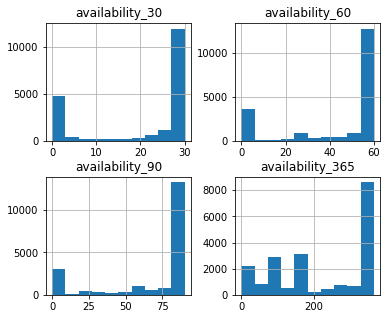

In [ ]:
# Distributions
data[['availability_30', 'availability_60', 'availability_90', 'availability_365']].hist(figsize=[6,5]);

In [ ]:
data.drop(['availability_30', 'availability_60', 'availability_365'], 
          axis=1, inplace=True)

**number_of_reviews,  	number_of_reviews_ltm, number_of_reviews_l30d** and **reviews_per_month** 

These features refer to the number of reviews in total, in the last twelve months, in the last 30 days and the proportion of reviews per month respectively. Since they will be highly correlated, we will only keep the one referring to the number of reviews in total.

In [ ]:
data.drop(['number_of_reviews_ltm', 'number_of_reviews_l30d',
           'reviews_per_month'], axis=1, inplace=True)

**review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location** and **review_scores_value**


These features refer to the review scores received by the properties in relation to a number of attributes: overall rating, accuracy in the description, cleanliness of the place, quality of checkin, host's communication, property location and value in terms of money paid.


review_scores_rating is the only one that has a different scale. We will transform it so they all range from 0 to 10

In [ ]:
data[['review_scores_rating', 'review_scores_accuracy', 
      'review_scores_cleanliness', 'review_scores_checkin', 
      'review_scores_communication', 'review_scores_location', 
      'review_scores_value']].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,13711.00,13698.00,13697.00,13698.00,13699.00,13698.00,13696.00
mean,94.72,9.68,9.41,9.82,9.79,9.83,9.45
std,9.02,0.88,1.04,0.72,0.76,0.64,0.98
min,20.00,2.00,2.00,2.00,2.00,2.00,2.00
25%,93.00,10.00,9.00,10.00,10.00,10.00,9.00
50%,97.00,10.00,10.00,10.00,10.00,10.00,10.00
75%,100.00,10.00,10.00,10.00,10.00,10.00,10.00
max,100.00,10.00,10.00,10.00,10.00,10.00,10.00


In [ ]:
data.review_scores_rating = data.review_scores_rating / 10

**calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms** and **calculated_host_listings_count_shared_rooms**


We already have the information of how many listings each host has (in the 'host_listings_count' feature), so these columns can be safely dropped.

In [ ]:
data.drop(['calculated_host_listings_count', 
           'calculated_host_listings_count_entire_homes', 
           'calculated_host_listings_count_private_rooms', 
           'calculated_host_listings_count_shared_rooms'],
          axis=1, inplace=True)

In [ ]:
print("Data shape so far:", data.shape)

Data shape so far: (20226, 73)


## 4. Exploratory Data Analysis

### PART I:

**Is it worth it to be a superhost in Buenos Aires? What about being verified?**

In [ ]:
 def plot_proportion_and_price(column, title, figsize=(15,5), 
                              prop_lim= 1, price_lim= 2800):
    """
    Function to plot proportions and median price for each level 
    of a given boolean column. 
    
    INPUTS:
    - column: string. Column to made plot of.
    - figsize: tupple. Size for figure.
    - prop_lim: int. Maximum proportion number, to make plor nicer.
    - price_lim: int. Minimum median price number, to make plor nicer.
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)      
    colors = ['darkcyan', 'firebrick', 'tab:orange', 'tab:blue']

    count = unique_hosts.groupby(column)[column].count()
    (count/unique_hosts.shape[0]).plot(kind="bar", ax=ax1, color= colors);
    ax1.set_title(str("Proportion of " + title), fontsize=16);
    ax1.set_ylim(top= prop_lim);

    price = data.groupby(column).price.median()
    price.plot(kind="bar", ax=ax2, color= colors);
    ax2.set_title("Median Price", fontsize=16);
    ax2.set_xlabel('');
    ax2.set_ylim(top= price_lim);

    for p in ax1.patches:
      txt = str((p.get_height() * 100).round(2)) + '%'
      txt_x = p.get_x() 
      txt_y = p.get_height() + 0.02
      ax1.text(txt_x, txt_y, txt)

    for p in ax2.patches:
      txt = str(p.get_height())
      txt_x = p.get_x() 
      txt_y = p.get_height() + 40
      ax2.text(txt_x, txt_y, txt)

    plt.show()

- **Being a superhost**

In [ ]:
unique_hosts = data.drop_duplicates(subset='host_id')

In [ ]:
# proportion of hosts that are superhost
unique_hosts.host_is_superhost.value_counts() / unique_hosts.shape[0] * 100

0   78.34
1   21.66
Name: host_is_superhost, dtype: float64

In [ ]:
# median price for each group
data.groupby('host_is_superhost').price.median()

host_is_superhost
0    2507
1    2505
Name: price, dtype: int64

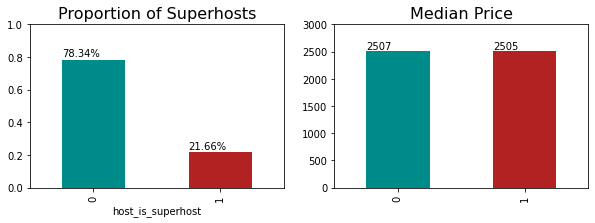

In [ ]:
# Plot proportion of superhosts and median price per category

plot_proportion_and_price('host_is_superhost', title= 'Superhosts', 
                          figsize=(10,3), prop_lim= 1, price_lim= 3000)

21.66% of host are superhosts, but **it doesn't seem to have an impact in the median price** of their listings, which is the same for both groups. 

Maybe being a superhost does not influence the price but it makes your properties more likely to be booked.


**Let's check if there's a difference in the proportion of listings that have at least one review for each group.** 

(This is not the ideal measure, since some properties might have been booked but no review was made, but it's the closest we have).

In [ ]:
# Plot proportion of listings reviewed per group

data['reviewed'] = np.where(data.number_of_reviews != 0, 1, 0)

def plot_poportion_of_reviewed(column):
  """
  Function to plot the proportion of reviewed listings for each level
  of a given boolean column. 
  
  INPUTS:
  - column: string. Column to made plot of.
  - figsize: tupple. Size for the figure.
  """
  
  x, y = column, 'reviewed'

  df = data.groupby(x)[y].value_counts(normalize=True)
  df = df.mul(100)
  df = df.rename('percent').reset_index()
  df[y] = df[y].replace({0: "False", 1: "True"})
  df[x] = df[x].replace({0.00: "It's not", 1.00: "It is"})

  graph = sns.catplot(x= x, y= 'percent', hue= y, kind='bar', 
              data= df, palette={'False': 'darkcyan', 'True': 'firebrick'})

  graph.ax.set_ylim(0,100)
  for p in graph.ax.patches:
      txt = str(p.get_height().round(2)) + '%'
      txt_x = p.get_x() 
      txt_y = p.get_height() + 1
      graph.ax.text(txt_x, txt_y, txt)

  plt.show();

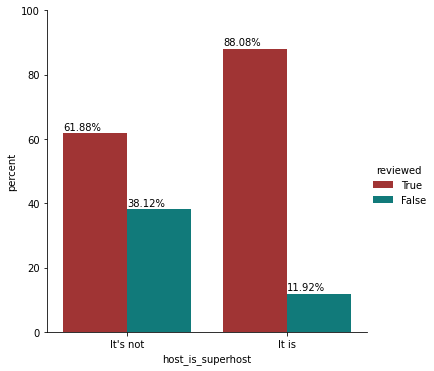

In [ ]:
plot_poportion_of_reviewed('host_is_superhost')

Both groups have more listings that have been reviewed than not. But for those who are superhosts, the percentage of listings reviewed is higher: 88.08% vs 61.88%. This suggest **certain advantage in being a superhost regarding the likelihood of having your properties booked**.

- **what about being verified?**

In [ ]:
unique_hosts.host_identity_verified.value_counts() / unique_hosts.shape[0] * 100

1   56.61
0   43.39
Name: host_identity_verified, dtype: float64

In [ ]:
data.groupby('host_identity_verified').price.median()

host_identity_verified
0    2424
1    2594
Name: price, dtype: int64

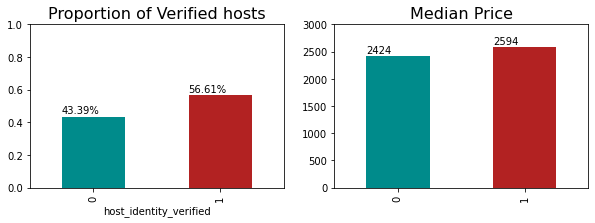

In [ ]:
# Plot proportion of hosts verified and median price per category

plot_proportion_and_price('host_identity_verified', title= 'Verified hosts', 
                          figsize=(10,3), prop_lim= 1, price_lim= 3000)

56.6% of host are verified, but **it doesn't seem to have an impact in the median price** of their listings, which is almost the same for both groups. 


Let's see if it influences the likelihood of being booked for their properties. 

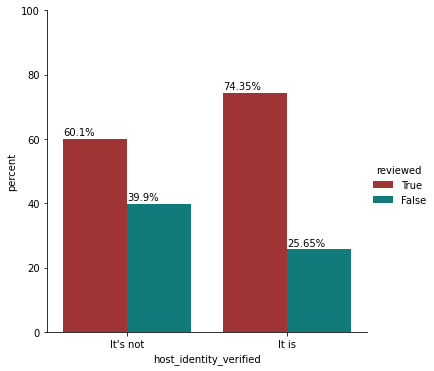

In [ ]:
# Plot proportion of listings reviewed per group 

plot_poportion_of_reviewed('host_identity_verified')

Both groups have more reviewed listings than not, but it seems than **being verified makes it more likely for your properties to be booked**: 74.35% of the listings were reviewed for verified hosts, vs 60.1% of the listings for those who are not.

Let's compare both classes now:

- **superhosts vs verified hosts**

In [ ]:
# create column to keep track of what kind of host is it

data['host_class'] = 0

# function to fill column
def fill_host_class(row):
  """ Function to fill column host_class according to the type of host,
  i.e. whether they are superhost, verified, both or neither. """
  
  sh = row.host_is_superhost
  v = row.host_identity_verified

  if v and sh: row.host_class = 'Both'
  elif sh: row.host_class = 'SH'
  elif v: row.host_class = 'Verified'
  else: row.host_class = 'None'

  return row

# fill column
data = data.apply(fill_host_class, axis=1) #ok

In [ ]:
unique_hosts = data.drop_duplicates(subset='host_id')

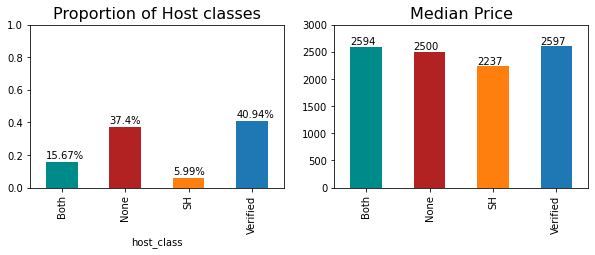

In [ ]:
plot_proportion_and_price('host_class', title= 'Host classes', 
                          figsize=(10,3), prop_lim= 1, price_lim= 3000)

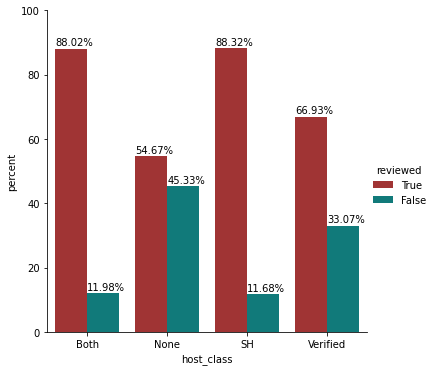

In [ ]:
plot_poportion_of_reviewed('host_class')

According to the data, **being verified only is the most popular option**: 40.94% of hosts choose to have their identity verified while not being superhosts.

Interestingly, there's no difference between the proportion of reviewed listings for hosts that are only superhost vs those that are superhosts _and verified_. This suggest that **being verified does not add any value if you are already a superhost**, at least regarding to the likelihood of having your properties booked.

It does seem better to be verified than not, in the case you are not a superhost, since verified hosts have almost 67% of their listings reviewed vs the almost 55% for those who are not.

But overall, **being a superhost seems to be more important than having your identity verified**, in relation to the likelihood of your properties for being booked.

In [ ]:
data.drop(['reviewed', 'host_class', 'host_id'], axis=1, inplace=True)

### PART II: 

**What are the prices in different neighbourhoods?**

**median price per neighbourhood**

To be able to compare median prices between different neighbourhoods, we will need to calculate confidence intervals (CI) for our medians.

Since it's not possible to calculate CI for neighbourhoods that have 5 or less listings, we will exclude them from the analysis. For those with more than 5 but less 71, we will calculate CI using a table provided in [this book](https://perfeval.epfl.ch/) by Jean-Yves Le Boudec. For neighbourhoods with more than 70 listings, we will use a formula from the same book, which is itself a special case of the formula given by Campbell & Gardner (1988) in [this paper](https://www.researchgate.net/publication/20024578_Calculating_confidence_intervals_for_non-parametric_analyses).

This is the table for the case of more than 5 but less than 71 listings:

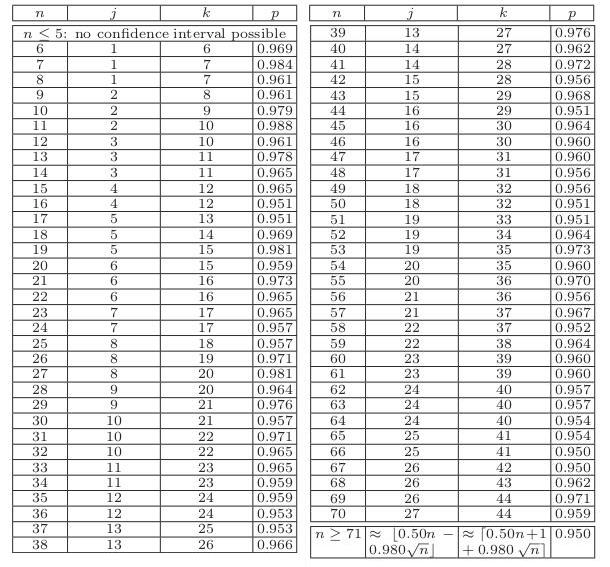

In [ ]:
# creating dataframe of number of listings and median price for each neighbourh.
nbhood_df = pd.DataFrame(data.groupby('neighbourhood').neighbourhood.count())
nbhood_df['median_price'] = data.groupby('neighbourhood').price.median()

nbhood_df.rename(columns= {'neighbourhood': 'n_listings'}, inplace=True)

In [ ]:
nbhood_df[nbhood_df.n_listings <=5]

,n_listings,median_price
neighbourhood,,
Villa Lugano,2,1540.00
Villa Riachuelo,3,2016.00
Villa Soldati,3,5373.00


In [ ]:
# excluding listings with 5 or less listings
nbhood_df = nbhood_df[nbhood_df.n_listings >5]

In [ ]:
# n_listings ordered
nbhood_df.n_listings.sort_values().values

array([   8,   10,   11,   11,   14,   14,   15,   16,   16,   19,   25,
         27,   28,   32,   32,   35,   45,   55,   56,   62,   70,   85,
         87,   92,  111,  113,  125,  134,  183,  229,  268,  308,  336,
        373,  408,  621,  655,  758,  854,  856,  993, 1091, 1232, 3454,
       6251])

In [ ]:
# dict mapping n to j and k according to the table (for the values in n_listings)
# up to 70
n_jk = {7: (1,7), 9: (2, 8), 10: (2, 9), 12: (3,10), 13: (3,11), 14: (3, 11), 
        18: (5, 14), 22: (6,16), 23:(7,17), 27: (8, 20), 28: (9, 20), 29: (9,21),
        41: (14, 28), 50: (18,32), 53: (19, 35), 57: (21, 37), 63: (24, 40)}

In [ ]:
# 95% confidence intervals for the median price per neighbourhood
nbhoods = nbhood_df.index.tolist()
CI_median_price = dict()

for nbh in nbhoods:
  n = nbhood_df.loc[nbh].n_listings

  # using table (for n up to 70)
  if n in n_jk.keys():
    j, k = n_jk[n]

  # using formula (if n> 70)
  else:
    j = int(0.5 * n - 0.98 * np.sqrt(n))
    k = math.ceil(0.5 * n + 1 + 0.98 * np.sqrt(n))

  ordered_prices = data[data.neighbourhood == nbh].price.sort_values().tolist()
  lower_value, upper_value = ordered_prices[j-1], ordered_prices[k-1]
  CI_median_price[nbh] = (lower_value, upper_value)

In [ ]:
CI_df = pd.DataFrame({'95% CI': [v for k,v in CI_median_price.items()]}, 
                     index= CI_median_price.keys())
CI_df.head()

,95% CI
Agronomia,"(895, 2350)"
Almagro,"(1849, 2100)"
Balvanera,"(1789, 1968)"
Barracas,"(1789, 2594)"
Belgrano,"(2415, 2684)"


In [ ]:
nbhood_CI_df = nbhood_df.join(CI_df)
nbhood_CI_df.sort_values(by='median_price', ascending=False)[:10]

,n_listings,median_price,95% CI
neighbourhood,,,
Puerto Madero,229,7783.00,"(6716, 8141)"
Floresta,28,3000.00,"(1075, 5499)"
Palermo,6251,2955.00,"(2863, 3045)"
Villa Real,10,2725.00,"(890, 11963)"
Recoleta,3454,2686.00,"(2684, 2850)"
Retiro,1091,2684.00,"(2505, 2686)"
Liniers,16,2674.50,"(1681, 3600)"
Belgrano,856,2507.00,"(2415, 2684)"
Nuñez,373,2507.00,"(2300, 2686)"


- From this table, we can see that Puerto Madero is the most expensive neighbourhood with a median price of 7783$ per night. We are pretty confident this is the case according to this data, since our 95% CI does not overlap with the following neighbourhoods in the ranking which are Floresta and Palermo. It does overlap with Villa Real, but this neighbourhood has a CI too broad to be informative, since it only has 10 listings and some extreme values.

- We can also see that some neighbourhoods, such as Floresta, Villa Real and Liniers have much broader confidence intervals, because their listings are considerable fewer and their prices are spread out, so we can't tell much about the median price in those cases.



**Let's consider median price in the neighbourhoods with more than 100 listings**.

In [ ]:
nbhood_morethan100 = nbhood_CI_df[nbhood_CI_df.n_listings >= 100]
nbhood_morethan100.sort_values(by='median_price', ascending=False)

,n_listings,median_price,95% CI
neighbourhood,,,
Puerto Madero,229,7783.00,"(6716, 8141)"
Palermo,6251,2955.00,"(2863, 3045)"
Recoleta,3454,2686.00,"(2684, 2850)"
Retiro,1091,2684.00,"(2505, 2686)"
Nuñez,373,2507.00,"(2300, 2686)"
...,...,...,...
Constitucion,268,1838.50,"(1700, 2058)"
Balvanera,993,1800.00,"(1789, 1968)"
Saavedra,111,1800.00,"(1791, 2149)"


Now we can see that there's a ranking that's a bit clearer:

- 1) Puerto Madero 
- 2) Palermo
- 3) Recoleta
- 4) Retiro, Nuñez, Belgrano, Colegiales.
- 5) San Nicolas
- 6) Monserrat, Villa Urquiza, Chacarita, Caballito, Almagro
- 7) Villa Crespo, Constitucion, Balvanera, Saavedra, San Cristobal, Boca

We still have some broad overlapping intervals, such in the case of Barracas.

**Let's see what happens when we only consider listings that have at least one review**, i.e. properties we are sure they have been booked at least once (although we are aware we are excluding properties that have been booked but no review was made, as well as properties that might have realistic prices but they are new listings).

Since each host is free to set the price they want, there're some extreme values that can be distorting our analysis, specifically making our CIs unnecesary broad.

Maybe some properties are charged an amount of money no one ever paid, and we are interested in finding a realistic median price for each neighbourhood, i.e. a useful value that can inform the decision of a new host about the price they should set for their listing.




**more than 100 listings and at least one review**

In [ ]:
# df with n_listings and median price only with listings with at least one review

data_reviewed = data[data.number_of_reviews != 0]
nbhood_df_reviewed = pd.DataFrame(data_reviewed.groupby(
    'neighbourhood').neighbourhood.count())
nbhood_df_reviewed['median_price'] = data_reviewed.groupby(
    'neighbourhood').price.median()
nbhood_df_reviewed.rename(columns= {'neighbourhood': 'n_listings'}, inplace=True)

In [ ]:
# excluding neighbourhoods with less than 100 listings
nbhood_reviewed_morethan100 = nbhood_df_reviewed[
                                        nbhood_df_reviewed.n_listings >=100]

In [ ]:
# 95% CI

nbhoods = list(nbhood_reviewed_morethan100.index)
CI_reviewed_morethan100 = dict()

for nbh in nbhoods:
  n = nbhood_reviewed_morethan100.loc[nbh].n_listings
  
  # formula (because always n > 70)
  j = int(0.5 * n - 0.98 * np.sqrt(n))
  k = math.ceil(0.5 * n + 1 + 0.98 * np.sqrt(n))

  ordered_prices = data_reviewed[data_reviewed.neighbourhood == nbh].price.sort_values().tolist()

  lower_value, upper_value = ordered_prices[j-1], ordered_prices[k-1]
  CI_reviewed_morethan100[nbh] = (lower_value, upper_value)

In [ ]:
CI_reviewed_morethan100_df = pd.DataFrame(
    {'95% CI': [v for k,v in CI_reviewed_morethan100.items()]}, 
    index= CI_reviewed_morethan100.keys())

In [ ]:
nbhood_CI_df_reviewed_morethan100 = nbhood_reviewed_morethan100.join(
    CI_reviewed_morethan100_df)

nbhood_CI_df_reviewed_morethan100.sort_values(by='median_price', ascending=False)

,n_listings,median_price,95% CI
neighbourhood,,,
Puerto Madero,158,6847.00,"(6173, 8052)"
Palermo,4599,2761.00,"(2684, 2863)"
Recoleta,2412,2684.00,"(2684, 2700)"
Belgrano,577,2505.00,"(2328, 2684)"
Nuñez,260,2418.00,"(2237, 2686)"
Retiro,743,2328.00,"(2237, 2505)"
San Telmo,456,2244.00,"(2200, 2531)"
Colegiales,281,2239.00,"(2237, 2507)"
San Nicolas,860,2237.00,"(2058, 2237)"


Considering only neighbourhoods with 100 or more reviewed listings, we are more confident now about the following ranking of median prices:
- 1) Puerto Madero
- 2) Palermo and Recoleta
- 3) Belgrano, Nuñez, Retiro, San Telmo, Colegiales
- 4) San Nicolas, Villa Urquiza, Chacarita, Monserrat
- 5) Caballito, Almagro, Villa Crespo, Constitucion, Balvanera


Ok, considering only listings with reviews shed light to the difference between neighbourhoods' median prices. But what happens with those neighbourhoods that don't have enough reviewed listings to be considered? How can we extract any information for potential host with properties in those locations?

Let's perform clustering for these listings to be able to group them according to their price and location (considering coordinates, but not following neighbourhoods borders strictly). We will then calculate the median price for each cluster, as well as their CI.

We will only consider reviewed listings from neighbourhoods with less than 100 listings.

In [ ]:
# nbhoods with less than 100 reviewed listings
nbs_to_consider = nbhood_df_reviewed[nbhood_df_reviewed.n_listings <100].index
data_lessthan100_reviewed = data_reviewed[
                              data_reviewed.neighbourhood.isin(nbs_to_consider)]

data_to_cluster = data_lessthan100_reviewed[['longitude', 'latitude', 'price', 
                                             'neighbourhood']]

In [ ]:
data_to_cluster.shape

(790, 4)

In [ ]:
data_to_cluster.head(2)

,longitude,latitude,price,neighbourhood
id,,,,
79247,-58.42,-34.62,1197,Boedo
235667,-58.38,-34.64,6179,Barracas


In [ ]:
# reading geojson file for buenos aires neighbourhoods' geometry
map_df = gpd.read_file('sample_data/neighbourhoods.geojson')
map_df.drop('neighbourhood_group', axis=1, inplace=True)
map_df.set_index('neighbourhood', inplace=True)

# geometry plus n_listings and median_price
nbhood_map = map_df.join(nbhood_df_reviewed)
nbhood_map = nbhood_map.replace(np.nan, 0)

In [ ]:
# it's important that is a GeoDataFrame
type(nbhood_map)

geopandas.geodataframe.GeoDataFrame

Let's have a look. Neighbourhoods are coloured according to their median_price (if we don't have data for a given neighbourhood, it will be coulored as 0), and the purple dots are the listings we need to find groups for:

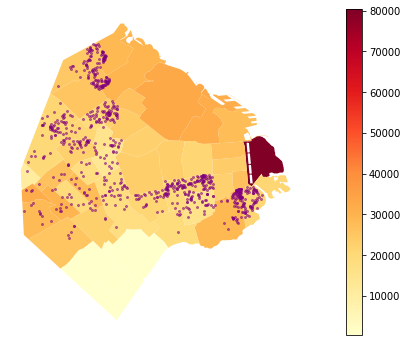

In [ ]:
# Plotting listings that need to be clustered on top of bsas map

fig, ax = plt.subplots(1, figsize=(15, 6))
nbhood_map.plot(column='median_price', cmap="YlOrRd", ax=ax)

ax.axis('off')

x, y = data_to_cluster['longitude'].values, data_to_cluster['latitude'].values
ax.scatter(x, y, color='purple', alpha=0.5, s=4)

sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(
    vmin=min(data_to_cluster.price), vmax=max(data_to_cluster.price)))
sm._A = []
cbar = fig.colorbar(sm)

plt.show();

**Clustering**

We will cluster these listings into 3 different groups to see if that gives us a more meaningful representation of their value.
We will plot the clusters on the map and we will calculate the median price and 95% CI for each group.

In [ ]:
def cluster_and_median_prices(data_reviewed, k, how='all', plot=True):
  """
  Function to find k clusters, plot clusters on buenos aires map,
  and get a dataframe with n_listings, median_price and 95% confidence
  intervals per cluster.

  INPUTS:
  - data_reviewed: df only with reviewed listings
  - k: number of clusters between 2 and 6
  - how: 'all' if using all reviewed listings, 'rest' if using only
  listings belonging to neighbourhoods with less than 100 reviewed listings
  - plot: plots clusters on buenos aires map if True

  OUTPUTS: 
  - clusters_CI_df: df with n_listings, median_price and CIs for each cluster
  - listings_clustered_df: df with price, neighbourhood and cluster per listing

  """

  nbhood_df_reviewed = pd.DataFrame(
      data_reviewed.groupby('neighbourhood').neighbourhood.count())
  nbhood_df_reviewed['median_price'] = data_reviewed.groupby(
      'neighbourhood').price.median()
  nbhood_df_reviewed.rename(
      columns= {'neighbourhood': 'n_listings'}, inplace=True)

  # reading geojson file for buenos aires neighbourhoods' geometry
  map_df = gpd.read_file('sample_data/neighbourhoods.geojson')
  map_df.drop('neighbourhood_group', axis=1, inplace=True)
  map_df.set_index('neighbourhood', inplace=True)

  # geometry plus n_listings and median_price
  nbhood_map = map_df.join(nbhood_df_reviewed)
  nbhood_map = nbhood_map.replace(np.nan, 0)

  if how == 'all':
    nbs_to_consider = list(nbhood_df_reviewed.index)
    data_to_consider = data_reviewed[
                            data_reviewed.neighbourhood.isin(nbs_to_consider)]
    data_to_cluster = data_to_consider[['longitude', 'latitude', 'price', 
                                        'neighbourhood']]

  elif how == 'rest':
    nbs_to_consider = nbhood_df_reviewed[
                                nbhood_df_reviewed.n_listings <100].index
    data_lessthan100_reviewed = data_reviewed[data_reviewed.neighbourhood.isin(
                                                              nbs_to_consider)]
    data_to_cluster = data_lessthan100_reviewed[['longitude', 'latitude', 
                                                 'price', 'neighbourhood']]

  # clustering
  X = data_to_cluster.drop('neighbourhood', axis=1)

  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)

  kmeans = KMeans(n_clusters= k, random_state=42).fit(X_scaled)
  y_kmeans = kmeans.predict(X_scaled)

  clustered_data = data_to_cluster.copy()
  clustered_data['cluster'] = y_kmeans
  clustered_data.drop(['longitude', 'latitude'], axis=1, inplace=True)

  # df with price, neighbourhood and cluster per listing
  listings_clustered_df = data_to_cluster.drop(['longitude', 'latitude'], axis=1)
  listings_clustered_df['cluster'] = y_kmeans

  # df with n_listings, median_price and CIs per cluster
  clusters_df = pd.DataFrame(clustered_data.groupby(
      'cluster').size().values).rename(columns= {0: 'n_listings'})
  clusters_df['median_price'] = clustered_data.groupby(
      'cluster').price.median()

  clusters = list(clusters_df.index)
  CI_clusters = dict()

  for c in clusters:
    n = clusters_df.loc[c].n_listings
    
    # formula (because always n > 70)
    j = int(0.5 * n - 0.98 * np.sqrt(n))
    k = math.ceil(0.5 * n + 1 + 0.98 * np.sqrt(n))

    ordered_prices = clustered_data[
                      clustered_data.cluster == c].price.sort_values().tolist()

    lower_value, upper_value = ordered_prices[j-1], ordered_prices[k-1]
    CI_clusters[c] = (lower_value, upper_value)

  CI_clusters = pd.DataFrame({'95% CI': [v for k,v in CI_clusters.items()]}, 
                             index= CI_clusters.keys())
  clusters_CI_df = clusters_df.join(CI_clusters)

  if plot:

    # Plotting clusters on the map
    fig, ax = plt.subplots(1, figsize=(15, 6))
    nbhood_map.plot(column='median_price', cmap="YlOrRd", ax=ax)

    ax.axis('off')

    x = data_to_cluster['longitude'].values
    y = data_to_cluster['latitude'].values
    
    colors = np.array(["tab:blue", "purple", "darkcyan", "orange",  "gold", 
                       "firebrick", "darkgreen"])
    
    ax.scatter(x, y, c= colors[y_kmeans], alpha=0.5, s=4)

    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(
              vmin=min(data_to_cluster.price), vmax=max(data_to_cluster.price)))
    sm._A = []
    cbar = fig.colorbar(sm)

    centers = kmeans.cluster_centers_
    centers_to_plot = scaler.inverse_transform(centers)
    plt.scatter(centers_to_plot[:, 0], centers_to_plot[:, 1], c='black', s=100, 
                alpha=0.5);
    plt.show();

  return listings_clustered_df, clusters_CI_df

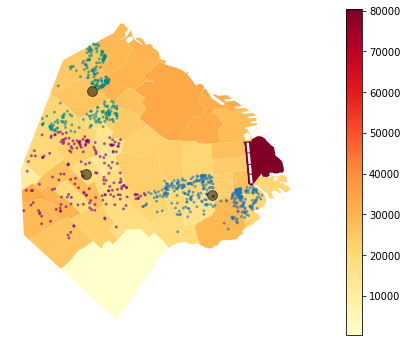

In [ ]:
k=3
listings_k3, clusters_k3 = cluster_and_median_prices(data_reviewed, k, 
                                                     how='rest', plot=True)

In [ ]:
clusters_k3.sort_values(by='median_price', ascending=False)

,n_listings,median_price,95% CI
2,254,1968,"(1791, 2149)"
1,192,1791,"(1612, 2000)"
0,344,1789,"(1631, 1880)"


Taking into account the clusters found, we can group neighbourhoods into zones to perform a final analysis that compares them with the rest of the neighbourhoods.

We don't want to divide neighbourhoods, since we want this analysis to be useful for potential new hosts, and having each neighbourhood in just one zone is much more practical information than delimiting zones with coordinates, for instance.

For the neighbourhoods that were split up in different clusters, we will choose the cluster that already contains more listings for that neighbourhood:

- Agronomia -- cluster 1
- Paternal -- cluster 1
- Villa Devoto -- cluster 2
- Villa Pueyrredon -- cluster 2
- Parque Chacabuco -- cluster 0

In [ ]:
listings_k3.groupby('neighbourhood').cluster.value_counts();

In [ ]:
def unify_neighbourhoods(row):
  """ Function to unify neighbourhoods that have been split into different
  clusters, into the same cluster (the one that already had more listings for
  that neighbourhood) """

  nbh = row.neighbourhood.lower()
  if nbh in ['agronomia', 'paternal']:
    row.cluster = 1
  elif nbh in ['villa devoto', 'villa pueyrredon']:
    row.cluster = 2
  elif nbh == 'parque chacabuco':
    row.cluster = 0
  
  return row

In [ ]:
listings_cleaned = listings_k3.apply(unify_neighbourhoods, axis=1)
listings_cleaned.groupby('cluster').size()

cluster
0    355
1    167
2    268
dtype: int64

We will replace clusters' numbers with the name of the neighbourhoods with the larger amount of listings in each cluster "and surround.", meaning it corresponds to that neighbourhood and its surroundings.

In [ ]:
listings_cleaned.groupby('cluster').neighbourhood.value_counts();

In [ ]:
zones_cleaned = listings_cleaned.copy()

zones_cleaned.cluster.replace({0: "Barracas and surround.",
                               1: "Flores and surround.",
                               2: "Saavedra and surround."}, inplace=True)

zones_cleaned = zones_cleaned.drop('neighbourhood', axis=1).rename(
    columns={'cluster': 'neighbourhood'})
zones_cleaned.head(2)

,price,neighbourhood
id,,
79247,1197,Barracas and surround.
235667,6179,Barracas and surround.


In [ ]:
# dict to map zones with neighbourhoods (will be useful later)

zones_nbhoods = {'Barracas and surround.': ['Barracas', 'San Cristobal', 'Boca', 
                                    'Boedo', 'Parque Patricios', 
                                    'Parque Chacabuco', 'Nueva Pompeya'],
         'Flores and surround.': ['Flores', 'Villa Del Parque', 'Paternal',
                                  'Floresta', 'Agronomia', 'Villa Gral. Mitre',
                                  'Liniers', 'Velez Sarsfield', 'Villa Luro',
                                  'Villa Santa Rita', 'Monte Castro', 'Mataderos',
                                  'Parque Avellaneda', 'Versalles', 'Villa Real'],
         'Saavedra and surround.': ['Saavedra', 'Coghlan', 'Villa Ortuzar',
                                    'Villa Devoto', 'Villa Pueyrredon', 
                                    'Parque Chas']}

**Let's now perform final analysis considering all neighbourhoods and zones**

In [ ]:
# create df with n_listings, median_price and CI per zone

zones_df = pd.DataFrame(zones_cleaned.groupby('neighbourhood').size()).rename(
    columns={0: 'n_listings'})
zones_df['median_price'] = zones_cleaned.groupby('neighbourhood').price.median()

# 95% CI
nbhoods = list(zones_df.index)
CI_zones = dict()

for nbh in nbhoods:
  n = zones_df.loc[nbh].n_listings
  
  # formula (because always n > 70)
  j = int(0.5 * n - 0.98 * np.sqrt(n))
  k = math.ceil(0.5 * n + 1 + 0.98 * np.sqrt(n))

  ordered_prices = zones_cleaned[
    zones_cleaned.neighbourhood == nbh].price.sort_values().tolist()

  lower_value, upper_value = ordered_prices[j-1], ordered_prices[k-1]
  CI_zones[nbh] = (lower_value, upper_value)

CI_zones = pd.DataFrame({'95% CI': [v for k,v in CI_zones.items()]}, 
                        index= CI_zones.keys())

zones_df_CI = zones_df.join(CI_zones)

In [ ]:
zones_df_CI.sort_values(by='median_price', ascending=False);

In [ ]:
# join zones with the rest of the data

all_data = pd.concat([nbhood_CI_df_reviewed_morethan100, zones_df_CI], axis=0)
all_data.sort_values(by='median_price', ascending=False)

,n_listings,median_price,95% CI
neighbourhood,,,
Puerto Madero,158,6847.00,"(6173, 8052)"
Palermo,4599,2761.00,"(2684, 2863)"
Recoleta,2412,2684.00,"(2684, 2700)"
Belgrano,577,2505.00,"(2328, 2684)"
Nuñez,260,2418.00,"(2237, 2686)"
Retiro,743,2328.00,"(2237, 2505)"
San Telmo,456,2244.00,"(2200, 2531)"
Colegiales,281,2239.00,"(2237, 2507)"
San Nicolas,860,2237.00,"(2058, 2237)"


**Final Ranking**

Checking what's the final median price for each neighbourhood/zone, and evaluating significance using the Kruskal-Wallis H Test (see below), we get this final ranking:

- 1) Puerto Madero
- 2) Palermo
- 3) Recoleta
- 4) Belgrano, Nuñez, Retiro, San Telmo, Colegiales
- 5) San Nicolas, Villa Urquiza, Chacarita, Monserrat, Saavedra and surroundings and Caballito
- 6) Almagro, Villa Crespo, Constitucion, Flores and surroundings
- 7) Balvanera, Barracas and surroundings

Let's see it on the map:

In [ ]:
# geometry for Saavedra and surround.
saavedra_surroundings = [map_df.loc[nbh, 'geometry'] \
                         for nbh in zones_nbhoods['Saavedra and surround.']]
saavedra_zone_geometry = unary_union(saavedra_surroundings)

# geometry for Flores and surround. 
flores_surroundings = [map_df.loc[nbh, 'geometry']  \
                       for nbh in zones_nbhoods['Flores and surround.']]
flores_zone_polygons = unary_union(flores_surroundings)
flores_zone_geometry = MultiPolygon([flores_zone_polygons])

# geometry for Barracas and surround.
barracas_surroundings = [map_df.loc[nbh, 'geometry'] \
                         for nbh in zones_nbhoods['Barracas and surround.']]
barracas_zone_polygons = unary_union(barracas_surroundings)
barracas_zone_geometry = MultiPolygon([barracas_zone_polygons])

# adding information to map_df
map_zones_df = map_df.copy()

map_zones_df.loc['Saavedra and surround.', 'geometry'] = saavedra_zone_geometry
map_zones_df.loc['Flores and surround.', 'geometry'] = flores_zone_geometry
map_zones_df.loc['Barracas and surround.', 'geometry'] = barracas_zone_geometry

# dropping neighbourhoods that were grouped in zones
to_drop = []
for zone, nbhoods in zones_nbhoods.items():
  for nbh in zones_nbhoods[zone]:
    to_drop.append(nbh)

map_zones_df.drop(to_drop, axis=0, inplace=True)

# dropping geometries we didn't use in this analysis
map_zones_df.drop(['Villa Lugano', 'Escollera Exterior', 'Villa Riachuelo', 
                   'Villa Soldati'], axis=0, inplace=True)

# joining map_zones_df with data regarding median_price
zones_price_geometry = map_zones_df.join(all_data)
type(zones_price_geometry) # check it's GeoDataFrame

geopandas.geodataframe.GeoDataFrame

In [ ]:
# create data_reviewed_zones 

def add_zones(row):
  """ Function to replace neighbourhoods with their corresponding zone, 
  if it corresponds. """
  nbh = row.neighbourhood
  for zone, nbhoods in zones_nbhoods.items():
    if nbh in nbhoods: row.neighbourhood = zone
  return row

In [ ]:
data_reviewed_zones = data_reviewed.apply(add_zones, axis=1)

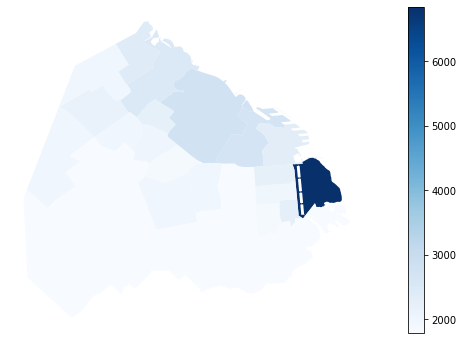

In [ ]:
# Plotting all neighbourhoods coloured according to median_price

fig, ax = plt.subplots(1, figsize=(15, 6))
zones_price_geometry.plot(column='median_price', cmap="Blues", ax=ax)

ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(
    vmin=min(zones_price_geometry.median_price), 
    vmax=max(zones_price_geometry.median_price)))
sm._A = [] 
cbar = fig.colorbar(sm)

plt.show();

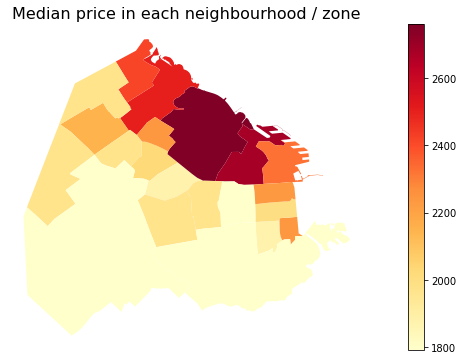

In [ ]:
# Plotting all EXCEPT Puerto Madero, which distorts the scale

geometry_no_puertomadero = zones_price_geometry.drop('Puerto Madero', axis=0)
data_no_puertomadero = data_reviewed_zones[
                          data_reviewed_zones.neighbourhood != "Puerto Madero"]

fig, ax = plt.subplots(1, figsize=(15, 6))
geometry_no_puertomadero.plot(column='median_price', cmap="YlOrRd", ax=ax)

ax.axis('off')
ax.set_title('Median price in each neighbourhood / zone', fontsize=16)

sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(
    vmin=min(geometry_no_puertomadero.median_price), 
    vmax=max(geometry_no_puertomadero.median_price)))
sm._A = [] 
cbar = fig.colorbar(sm)

plt.show();

#### Checking significances

In [ ]:
# we need all listings for each neighbourhood/zone with their prices
data_reviewed_zones = data_reviewed.apply(add_zones, axis=1)
zones_and_prices = data_reviewed_zones[['neighbourhood', 'price']]

# data dict to use with kruskal test
dd = dict()

for nbh in zones_and_prices.neighbourhood.unique():
  dd[nbh] = zones_and_prices[zones_and_prices.neighbourhood == nbh].price.values

In [ ]:
zones_and_prices.head();

In [ ]:
# Puerto Madero y Palermo

# compare samples
stat, p = kruskal(dd['Puerto Madero'], dd['Palermo'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=160.843, p=0.000
Different distributions


In [ ]:
# Palermo y Recoleta

# compare samples
stat, p = kruskal(dd['Palermo'], dd['Recoleta'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=10.727, p=0.001
Different distributions


In [ ]:
# Recoleta y Belgrano

# compare samples
stat, p = kruskal(dd['Recoleta'], dd['Belgrano'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=7.063, p=0.008
Different distributions


In [ ]:
# Belgrano, Nuñez, Retiro, San Telmo, Colegiales

# compare samples
stat, p = kruskal(dd['Belgrano'], dd['Nuñez'], dd['Retiro'],
                  dd['San Telmo'], dd['Colegiales'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=6.492, p=0.165
Same distributions


In [ ]:
# adding San Nicolas

# compare samples
stat, p = kruskal(dd['Belgrano'], dd['Nuñez'], dd['Retiro'],
                  dd['San Telmo'], dd['Colegiales'], dd['San Nicolas'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=32.404, p=0.000
Different distributions


In [ ]:
# San Nicolas, Villa Urquiza, Chacarita, Monserrat, Saavedra and surroundings, 
# and Caballito 

# compare samples
stat, p = kruskal(dd['San Nicolas'], dd['Villa Urquiza'], dd['Chacarita'], 
                  dd['Monserrat'], dd['Saavedra and surround.'], dd['Caballito'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=10.892, p=0.054
Same distributions


In [ ]:
# adding Almagro

# compare samples
stat, p = kruskal(dd['San Nicolas'], dd['Villa Urquiza'], dd['Chacarita'], 
                  dd['Monserrat'], dd['Saavedra and surround.'], dd['Caballito'],
                  dd['Almagro'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=17.782, p=0.007
Different distributions


In [ ]:
# Almagro, Villa Crespo, Constitucion, Flores and surroundings

# compare samples
stat, p = kruskal(dd['Almagro'], dd['Villa Crespo'], dd['Constitucion'], 
                  dd['Flores and surround.'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=4.502, p=0.212
Same distributions


In [ ]:
# adding Balvanera

# compare samples
stat, p = kruskal(dd['Almagro'], dd['Villa Crespo'], dd['Constitucion'], 
                  dd['Flores and surround.'], dd['Balvanera'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=10.662, p=0.031
Different distributions


In [ ]:
# Balvanera, Barracas and surroundings

# compare samples
stat, p = kruskal(dd['Balvanera'], dd['Barracas and surround.'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions')
else:
	print('Different distributions')

Statistics=0.014, p=0.906
Same distributions


### PART III:


**What attributes of a listing correlate with price?**

#### Data Preprocessing

In [ ]:
# data = load_and_clean()
data.shape

(20226, 72)

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 80)

In [ ]:
# missing values
data.isnull().mean();

In [ ]:
# separate data into categorical, boolean and numerical for preprocessing

cat_data = data.select_dtypes(include=['object'])
cat_cols = cat_data.columns

bool_data = data.select_dtypes(include=['int64'])
num_data = data.select_dtypes(include=['float64'])

# we drop numerical features in nature for bool_data
num_in_nature = ['accommodates', 'price', 'minimum_nights', 'maximum_nights',
       'availability_90', 'number_of_reviews']
       
bool_data.drop(num_in_nature, axis=1, inplace=True)
bool_cols = bool_data.columns

# we add them tu num_data
num_data = pd.concat([num_data, data[num_in_nature]], axis=1)
num_cols = num_data.columns

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
data.shape[1] ==  cat_data.shape[1] + bool_data.shape[1] + num_data.shape[1] # ok

True

**Categorical features**

- **missing values**

In [ ]:
cat_data.isnull().mean()

host_location          0.004
host_response_time     0.000
host_response_rate     0.000
host_acceptance_rate   0.000
neighbourhood          0.000
property_type          0.000
room_type              0.000
dtype: float64

*host_location*: we only have 0.4% of missing values. We will replace them with the mode.

In [ ]:
data.host_location.value_counts()

buenos aires      14124
other province     4333
other country      1683
Name: host_location, dtype: int64

In [ ]:
data.host_location = data.host_location.fillna(data.host_location.mode()[0])

In [ ]:
data.host_location.isnull().sum()

0

In [ ]:
# no missing values
bool_data.isnull().mean();

- **variability**

Let's check if our **categorical features** have enough values in each level to be informative:

In [ ]:
cat_data.columns

Index(['host_location', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'neighbourhood', 'property_type', 'room_type'],
      dtype='object')

In [ ]:
# variability for cateforical features

for feat in cat_data.columns:
 print(cat_data[feat].value_counts(), '\n')

buenos aires      14124
other province     4333
other country      1683
Name: host_location, dtype: int64 

unknown               8044
within an hour        5882
within a few hours    2632
within a day          2126
a few days or more    1542
Name: host_response_time, dtype: int64 

100%       8227
unknown    8044
<80%       2531
80-99%     1424
Name: host_response_rate, dtype: int64 

unknown    8444
100%       6472
<80%       2661
80-99%     2649
Name: host_acceptance_rate, dtype: int64 

Palermo              6251
Recoleta             3454
San Nicolas          1232
Retiro               1091
Balvanera             993
Belgrano              856
Monserrat             854
Almagro               758
Villa Crespo          655
San Telmo             621
Colegiales            408
Nuñez                 373
Caballito             336
Chacarita             308
Constitucion          268
Puerto Madero         229
Villa Urquiza         183
Barracas              134
San Cristobal         125
Boca      

*neighbourhood* have some levels with few values. We will group neighbourhoods with few listings according to the clustering we performed before (see Part II)

In [ ]:
# this is already in Part II but also here so Part III can work independently
# dict to map zones with neighbourhoods (will be useful later)

zones_nbhoods = {'Barracas and surround.': ['Barracas', 'San Cristobal', 'Boca', 
                                    'Boedo', 'Parque Patricios', 'Parque Chacabuco',
                                    'Nueva Pompeya'],
         'Flores and surround.': ['Flores', 'Villa Del Parque', 'Paternal',
                                  'Floresta', 'Agronomia', 'Villa Gral. Mitre',
                                  'Liniers', 'Velez Sarsfield', 'Villa Luro',
                                  'Villa Santa Rita', 'Monte Castro', 'Mataderos',
                                  'Parque Avellaneda', 'Versalles', 'Villa Real'],
         'Saavedra and surround.': ['Saavedra', 'Coghlan', 'Villa Ortuzar',
                                    'Villa Devoto', 'Villa Pueyrredon', 'Parque Chas']}
                                    
def add_zones(row):
  nbh = row.neighbourhood
  for zone, nbhoods in zones_nbhoods.items():
    if nbh in nbhoods: row.neighbourhood = zone
  return row

In [ ]:
# grouping neighbourhoods into zones
data = data.apply(add_zones, axis=1)

There are 3 neighbourhoods with less than 5 listings and no reviews. We will drop those rows.

In [ ]:
data.neighbourhood.value_counts() < 5;

In [ ]:
# proportion of non reviewed listings per neighbourhood
data[data.number_of_reviews == 0].neighbourhood.value_counts() \
/ data.neighbourhood.value_counts();

In [ ]:
# drop neighbourhoods with 100% non reviewed listings
data = data[~data.neighbourhood.isin(['Villa Lugano', 'Villa Riachuelo', 
                                      'Villa Soldati'])]

In [ ]:
data.neighbourhood.value_counts()

Palermo                   6251
Recoleta                  3454
San Nicolas               1232
Retiro                    1091
Balvanera                  993
Belgrano                   856
Monserrat                  854
Almagro                    758
Villa Crespo               655
San Telmo                  621
Barracas and surround.     589
Colegiales                 408
Saavedra and surround.     395
Nuñez                      373
Flores and surround.       364
Caballito                  336
Chacarita                  308
Constitucion               268
Puerto Madero              229
Villa Urquiza              183
Name: neighbourhood, dtype: int64

For our **boolean features**, we will drop columns that have more than 90% of the values in just one level:

In [ ]:
bool_data.columns

Index(['host_is_superhost', 'host_identity_verified', 'instant_bookable',
       'host_about_info', 'internet', 'kitchen', 'bathroom_essentials',
       'long_term', 'heating', 'hangers', 'smart_tv', 'tv', 'air_conditioning',
       'workspace', 'hot_water', 'elevator', 'hair_dryer', 'iron',
       'dishes_silverware', 'white_goods', 'refrigerator', 'microwave',
       'stove_oven', 'coffee_maker', 'bed_linens', 'safety',
       'patio_balcony_garden', 'free_parking', 'paid_parking',
       'bedroom_extras', 'host_greets_you', 'private_entrance',
       'pool_hottub_spa_sauna', 'luggage_dropoff_allowed',
       'cleaning_before_checkout', 'gym', 'lock_on_bedroom', 'bbq',
       'building_staff', 'baby_friendly', 'other_small_electric',
       'nature_access', 'sound_system'],
      dtype='object')

In [ ]:
to_drop = []
for feat in bool_data.columns:
  feat_perc = bool_data[feat].value_counts() / bool_data.shape[0] * 100
  
  # if any level has less than 10% listings
  if any(value > 90 for value in feat_perc.values):
    to_drop.append(feat)

data.drop(to_drop, axis=1, inplace=True)
print("Columns dropped:", to_drop)

Columns dropped: ['internet', 'kitchen', 'bathroom_essentials', 'long_term', 'heating', 'smart_tv', 'cleaning_before_checkout', 'lock_on_bedroom', 'bbq', 'building_staff', 'other_small_electric', 'nature_access', 'sound_system']


In [ ]:
data.shape

(20218, 59)

- **Categorical encoding**

In [ ]:
cat_data.dtypes

host_location           object
host_response_time      object
host_response_rate      object
host_acceptance_rate    object
neighbourhood           object
property_type           object
room_type               object
dtype: object

Categorical columns that have an intrinsic order:
- host_response_time, host_response_rate and host_acceptance_rate

We will use **ordinal encoding**.

Categorical columns that does not have an intrinsic order:
- host_location, neighbourhood, property_type, room_type.

We will use **one hot encoding**.

In [ ]:
# ordinal encoding

data.host_response_time.replace({
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1,
    'unknown': 0}, inplace=True)

data.host_response_rate.replace({
    '100%': 3,
    '80-99%': 2,
    '<80%': 1,
    'unknown': 0}, inplace=True)

data.host_acceptance_rate.replace({
    '100%': 3,
    '80-99%': 2,
    '<80%': 1,
    'unknown': 0}, inplace=True)

In [ ]:
# one hot encoding

# columns to get dummies for
onehot_cols = ['host_location', 'neighbourhood', 'property_type', 'room_type']
data = pd.get_dummies(data, columns= onehot_cols, drop_first=True)

In [ ]:
# obs: uint8
data.dtypes

host_response_time          int64
host_response_rate          int64
host_acceptance_rate        int64
host_is_superhost           int64
host_listings_count       float64
                           ...   
property_type_house         uint8
property_type_other         uint8
room_type_Hotel room        uint8
room_type_Private room      uint8
room_type_Shared room       uint8
Length: 81, dtype: object

In [ ]:
data.shape

(20218, 81)

**Numerical features**

In [ ]:
# drop location data
data.drop(['longitude', 'latitude'], axis=1, inplace=True)

In [ ]:
# missing values
missing_cols = num_data.columns[num_data.isnull().mean() != 0]

In [ ]:
num_data[missing_cols].isnull().mean()

bedrooms                      0.152
beds                          0.010
review_scores_rating          0.322
review_scores_accuracy        0.323
review_scores_cleanliness     0.323
review_scores_checkin         0.323
review_scores_communication   0.323
review_scores_location        0.323
review_scores_value           0.323
bathrooms                     0.003
days_since_fr                 0.307
days_since_lr                 0.307
dtype: float64

In [ ]:
few_missing = ['bathrooms', 'bedrooms', 'beds']

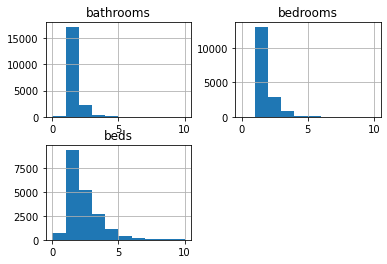

In [ ]:
num_data[few_missing].hist(range=[0,10]);

*bathrooms, bedrooms, beds* 

We will fill missing values with the median.

In [ ]:
data.bathrooms = data.bathrooms.fillna(data.bathrooms.median())
data.bedrooms = data.bedrooms.fillna(data.bedrooms.median())
data.beds = data.beds.fillna(data.beds.median())

*review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, days_since_fr, days_since_lr*    


Missing values for these columns actually mean those listings didn't have a review yet. We will replace them with "no reviews", and treat these features as categorical.

In [ ]:
review_scores_cols = ['review_scores_rating', 'review_scores_accuracy', 
               'review_scores_cleanliness', 'review_scores_checkin', 
               'review_scores_communication', 'review_scores_location', 
               'review_scores_value']

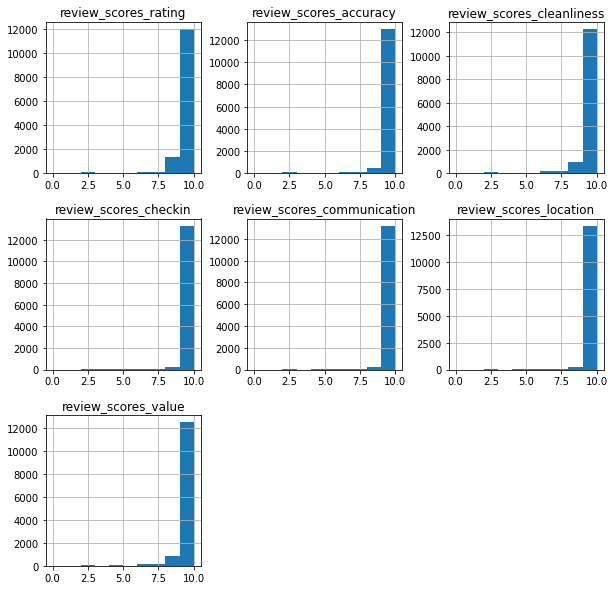

In [ ]:
data[review_scores_cols].hist(figsize=(10,10), range=[0,10]);

In [ ]:
def bins_and_nans(data, col, bins, labels, nan_tag):
  """ Function to create bins and replace missing values for a column.
  INPUTS:
  - data: datafram to transform.
  - col: column to create bins and replace missing values for.
  - bins: bins' cut points.
  - labels: labels for those bins.
  - nan_tag: string to replace missing values with.

  OUTPUT:
  - data: transformed dataframe.
  """

  data[col] = pd.cut(data[col], bins= bins, labels= labels, include_lowest=True)
  data[col] = data[col].replace({np.nan: nan_tag})

  return data


In [ ]:
# create bins and replace missing values for review_scores_cols

for c in review_scores_cols:
  data = bins_and_nans(data= data, col= c, bins= [0, 8.5, 9.5, 9.9, 10], 
                       labels= ['< 8.5', '8.5 - 9.4', '9.5 - 9.9', '10'],
                       nan_tag= 'no_reviews')

We will encode these new categorical features using an **ordinal encoding**

In [ ]:
for c in review_scores_cols:
  data[c].replace({
    '10': 4,
    '9.5 - 9.9': 3,
    '8.5 - 9.4': 2,
    '< 8.5': 1,
    'no_reviews': 0}, inplace=True)

*days_since_fr, days_since_lr*

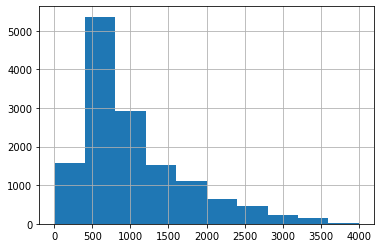

In [ ]:
# days since first review

data.days_since_fr.hist();

In [ ]:
# Binning time since first review

data = bins_and_nans(data, 'days_since_fr',
                       bins= [0, 730, 1460, np.inf],
                       labels= ['0-2 years', '2-4  years', '> 4 years'],
                       nan_tag= 'no_reviews')

# renaming column
data = data.rename(columns= {'days_since_fr': 'time_since_first_review'})

In [ ]:
# ordinal encoding

data.time_since_first_review.replace({
    '0-2 years': 3,
    '2-4  years': 2,
    '> 4 years': 1,
    'no_reviews': 0}, inplace=True)

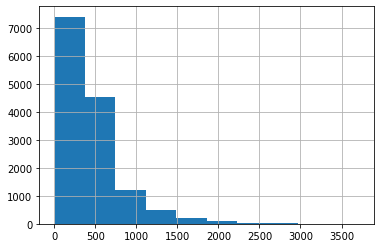

In [ ]:
# days since last review

data.days_since_lr.hist();

In [ ]:
# Binning time since last review

data = bins_and_nans(data, 'days_since_lr',
                       bins= [0, 182, 365, 730, np.inf],
                       labels= ['0-6 months', '6-12 months', '1-2 years', 
                                '> 2 years'],
                       nan_tag= 'no_reviews')

# renaming column
data = data.rename(columns= {'days_since_lr': 'time_since_last_review'})

In [ ]:
# ordinal encoding

data.time_since_last_review.replace({
    '0-6 months': 4,
    '6-12 months': 3,
    '1-2 years': 2,
    '> 2 years': 1,
    'no_reviews': 0}, inplace=True)

- **Price** (target)

In [ ]:
data.price.describe()

count     20218.000
mean       5176.586
std       67172.653
min         218.000
25%        1612.000
50%        2507.000
75%        4030.000
max     8946021.000
Name: price, dtype: float64

Prices range from 218 to 8946021 per night. Less than 1% of the listings have prices higher than 30000. We will reduce them to 30000.

In [ ]:
# proportion of listings with prices higher than 30000
data[data.price > 30000].shape[0] / data.shape[0]

0.00929864477198536

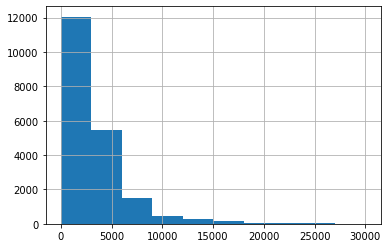

In [ ]:
# distribution up to 30000
data.price.hist(range=[0, 30000]);

In [ ]:
# replacing values higher than 30000
data.loc[data.price > 30000, 'price'] = 30000

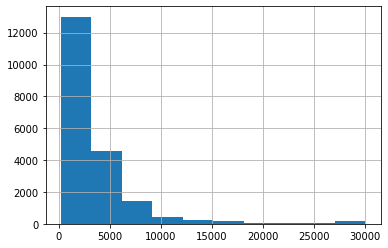

In [ ]:
data.price.hist();

In [ ]:
data.dtypes; # all numerical

data.shape

(20218, 79)

#### Assesing Multicollinearity

We will use Random Forest to model our data and find what features contribute the most to predicting price.

Since we will want to rely on the feature importances found by our model, we will need to check for **multicollinearity** first.  We care more about how much each individual feature affects the target variable, rather than a group of features.

Let's plot a heatmap before:

In [ ]:
data.shape

(20218, 79)

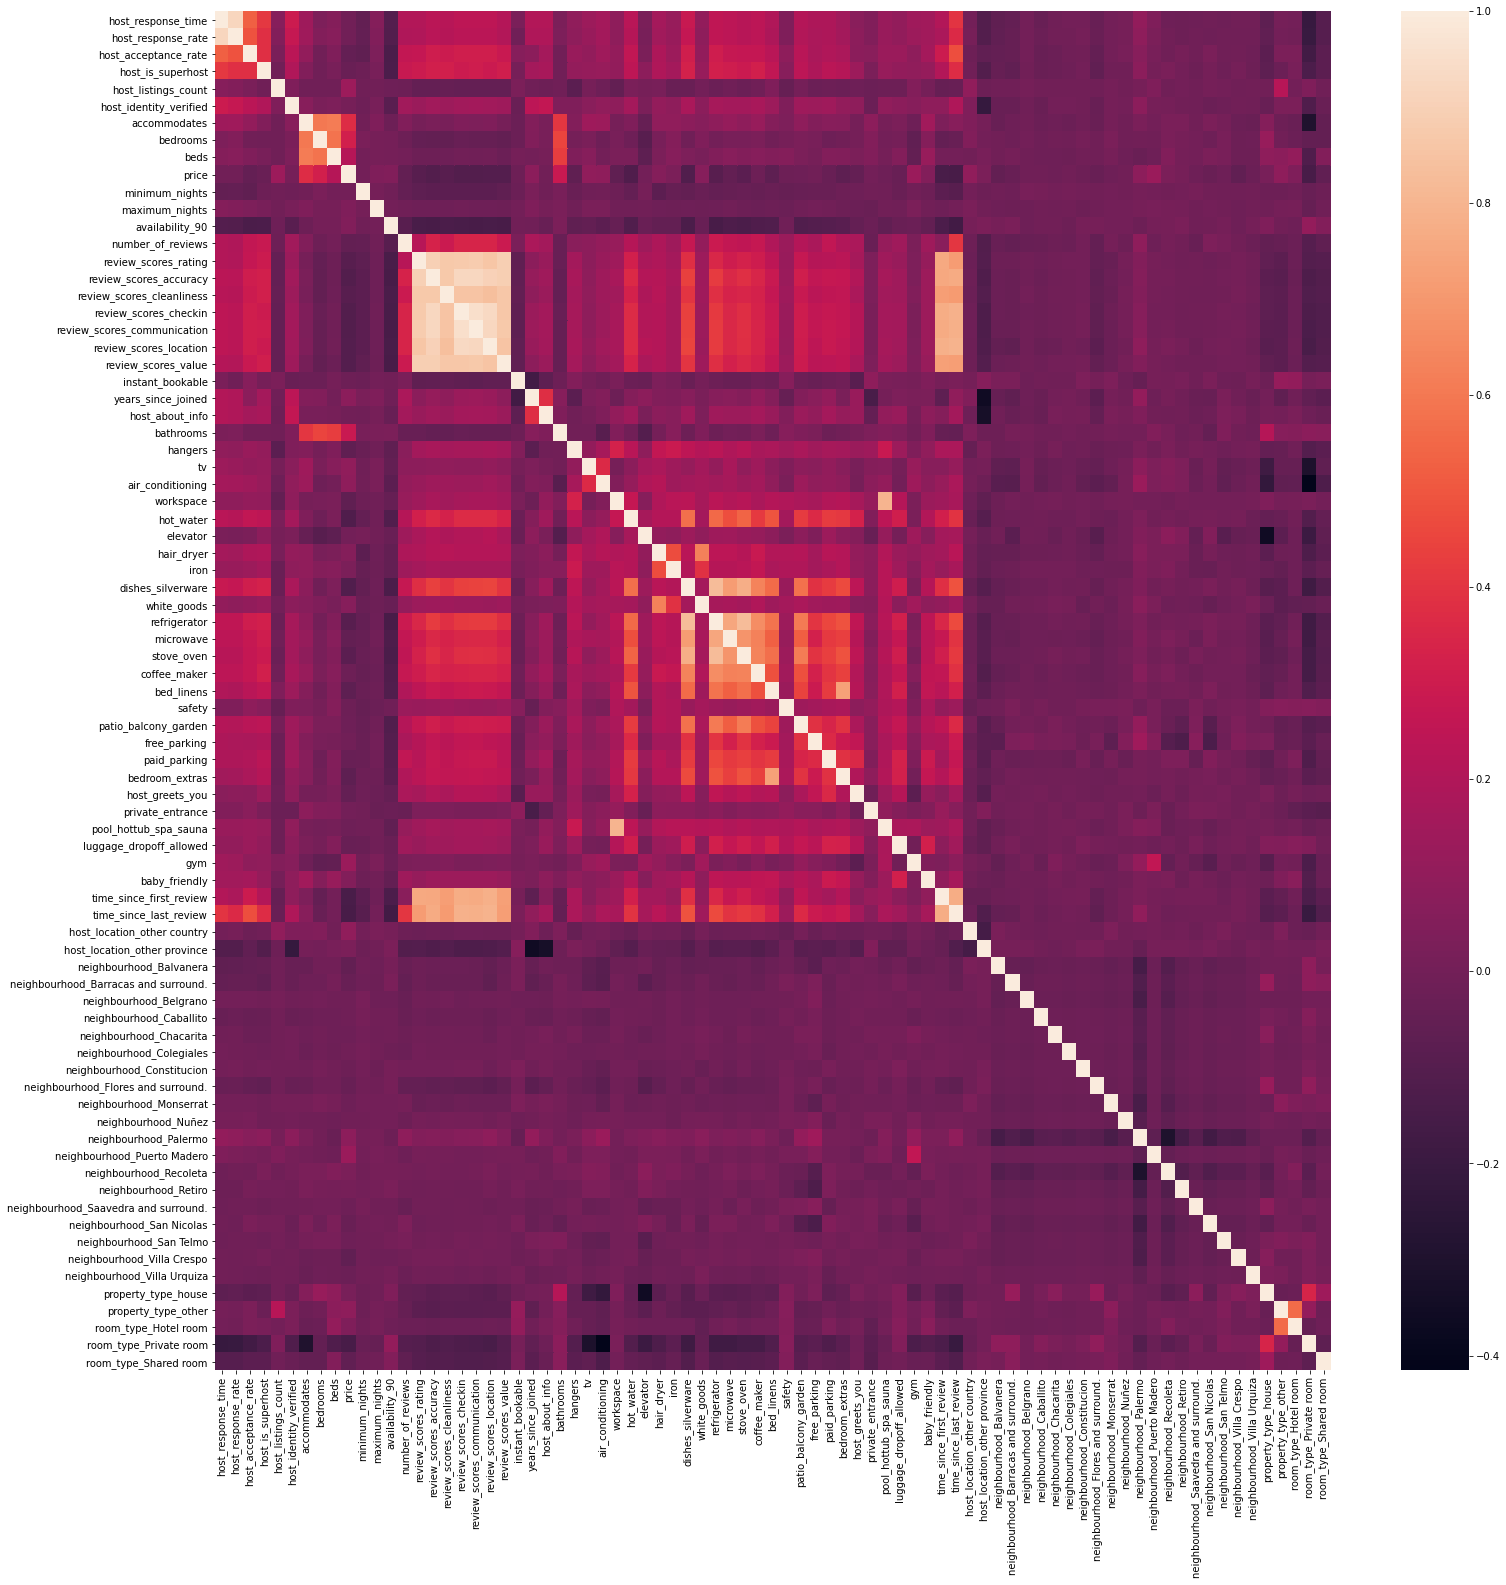

In [ ]:
f, ax = plt.subplots(figsize= (25,25))
sns.heatmap(data.corr(), annot=False, fmt=".2f");

We will zoom in in the highly correlated features:

In [ ]:
less_correlated_cols = ['host_location_other country',
       'host_location_other province', 'neighbourhood_Balvanera',
       'neighbourhood_Barracas and surround.', 'neighbourhood_Belgrano',
       'neighbourhood_Caballito', 'neighbourhood_Chacarita',
       'neighbourhood_Colegiales', 'neighbourhood_Constitucion',
       'neighbourhood_Flores and surround.', 'neighbourhood_Monserrat',
       'neighbourhood_Nuñez', 'neighbourhood_Palermo',
       'neighbourhood_Puerto Madero', 'neighbourhood_Recoleta',
       'neighbourhood_Retiro', 'neighbourhood_Saavedra and surround.',
       'neighbourhood_San Nicolas', 'neighbourhood_San Telmo',
       'neighbourhood_Villa Crespo', 'neighbourhood_Villa Urquiza',
       'property_type_house', 'property_type_other', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room']

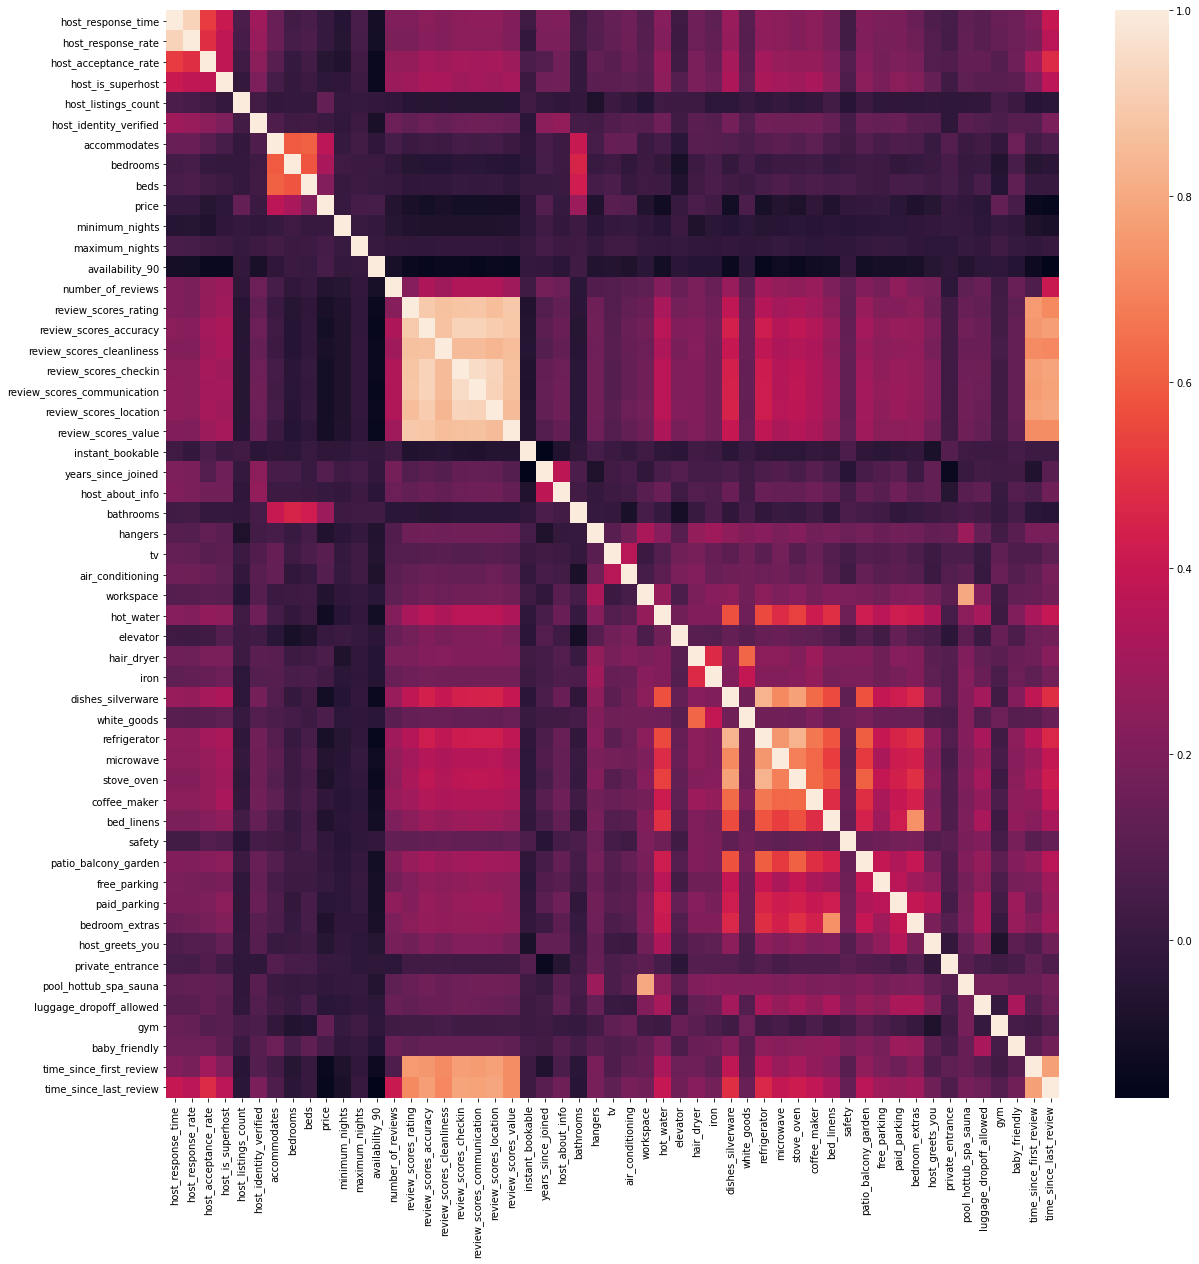

In [ ]:
f, ax = plt.subplots(figsize= (20,20))
most_correlated_data = data.drop(less_correlated_cols, axis=1)
sns.heatmap(most_correlated_data.corr(), annot=False, fmt=".2f");

Let's assess multicollinearity now using the **Variance Inflation Factor (VIF)**

Correlation matrix and scatter plots only show the bivariate relationship between the independent variables. VIF is preferred as it can show the correlation of a variable with a group of other variables.

- VIF = 1 means there is no correlation between the independent variable and the other variables
- VIF exceeding 10 indicates very high multicollinearity between the independent variable in question and the others.



We will start dropping variables with the largest VIF value because its trend is highly captured by other variables. VIF values for other variables should be reduced as well, to some extent.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """Function to calculate variance inflation factor (VIF) 
    given a dataframe with numerical variables"""

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
target = 'price'
X = data.drop(target, axis=1)

In [ ]:
VIF_df = calculate_vif(X)
VIF_df.sort_values(by='VIF', ascending=False)[:10]

,variables,VIF
16,review_scores_checkin,41.417
17,review_scores_communication,40.204
14,review_scores_accuracy,29.609
18,review_scores_location,29.386
13,review_scores_rating,20.349
19,review_scores_value,17.147
0,host_response_time,16.335
1,host_response_rate,15.110
46,pool_hottub_spa_sauna,14.189
15,review_scores_cleanliness,13.794


- As we can see in our heatmap and in the VIF scores, columns related to review scores are highly correlated. 

We can safely drop all but the main one: review_scores_rating, which is the overall rating score. We will want to know how important the review score is, and if it turns out to be a strong predictor, it is known in practice what the score is about (checkin quality, communiaction, accuracy, etc). Furthermore, if it is important, the differences between diverse review scores can be explored in an additional analysis. 

In [ ]:
# check VIF after dropping columns related to review scores. We will keep review_scores_rating

X_red = X.drop(['review_scores_checkin', 'review_scores_communication', 
                'review_scores_accuracy', 'review_scores_location', 
                'review_scores_value', 'review_scores_cleanliness'], axis=1)

VIF_df_red = calculate_vif(X_red)


In [ ]:
VIF_df_red.sort_values(by='VIF', ascending=False)[:10]

,variables,VIF
0,host_response_time,16.285
1,host_response_rate,15.087
40,pool_hottub_spa_sauna,14.183
45,time_since_last_review,11.937
44,time_since_first_review,11.125
28,refrigerator,10.962
21,workspace,10.297
26,dishes_silverware,10.023
6,accommodates,9.746
18,hangers,9.494


- host_response_time is highly correlated to host_response_rate. We will drop the first one
- time_since_first_review is highly correlated to time_since_first_review. We will drop the first one

In [ ]:
X_red = X.drop(['review_scores_checkin', 'review_scores_communication', 
                'review_scores_accuracy', 'review_scores_location', 
                'review_scores_value', 'review_scores_cleanliness'], axis=1)

X_red = X_red.drop(['host_response_time', 'time_since_first_review'], axis=1)

VIF_df_red = calculate_vif(X_red)
VIF_df_red.sort_values(by='VIF', ascending=False)[:10]

,variables,VIF
39,pool_hottub_spa_sauna,14.178
27,refrigerator,10.937
20,workspace,10.296
25,dishes_silverware,10.002
5,accommodates,9.730
17,hangers,9.459
26,white_goods,9.323
18,tv,8.777
19,air_conditioning,8.607
43,time_since_last_review,7.753


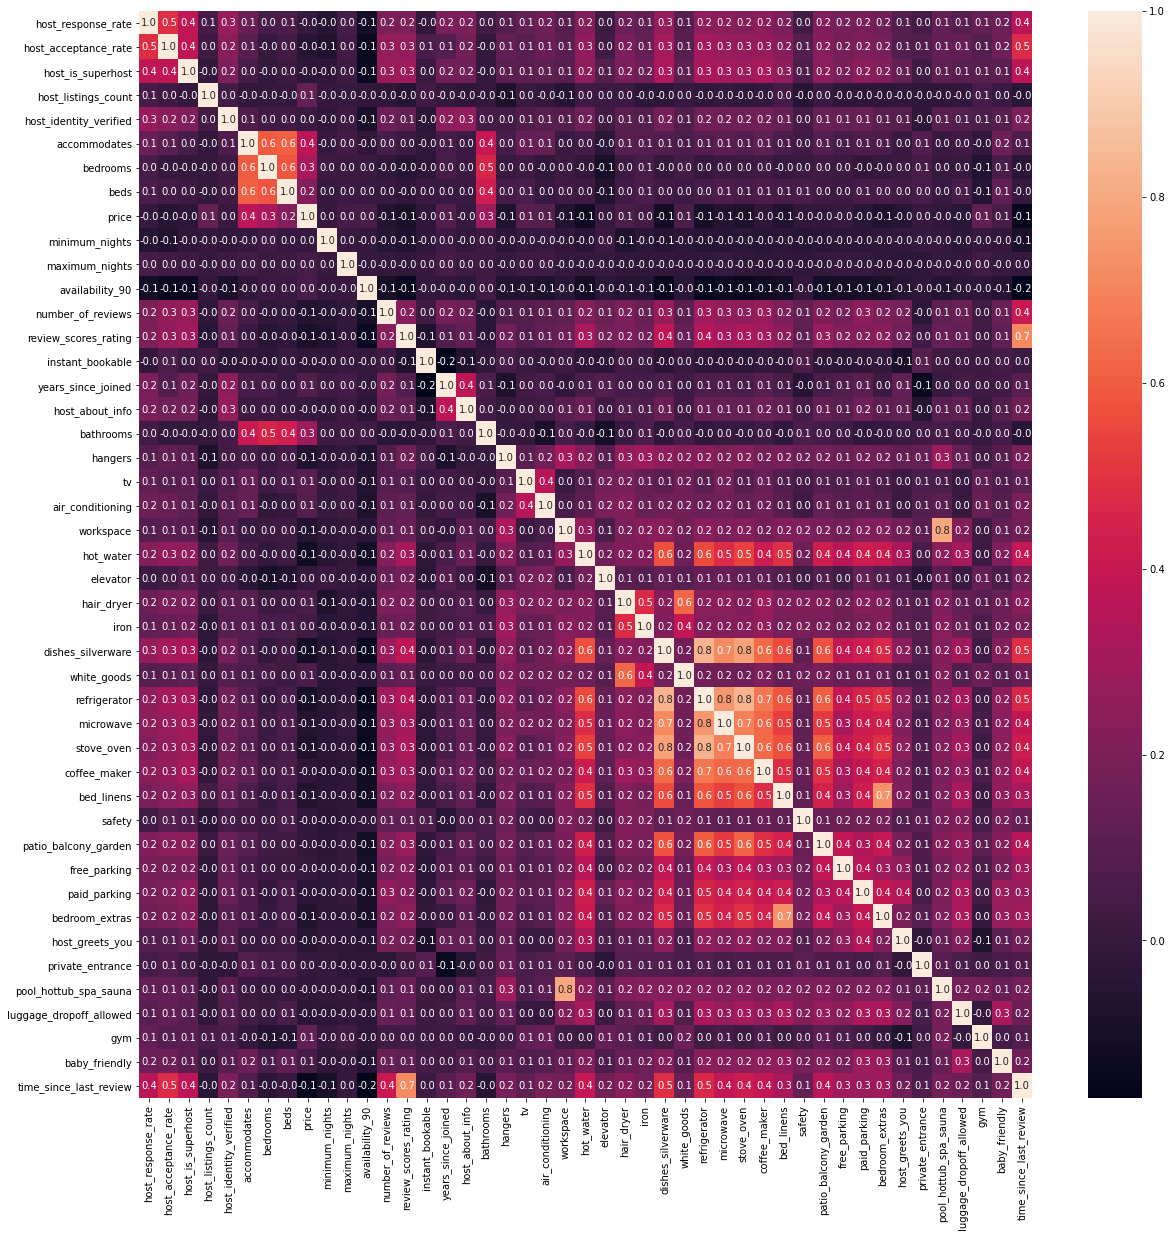

In [ ]:
# let's plot a new heatmap with the most correlated columns so far

most_correlated_data_red = most_correlated_data.drop(
    ['review_scores_checkin', 'review_scores_communication', 
     'review_scores_accuracy', 'review_scores_location', 
     'review_scores_value', 'review_scores_cleanliness', 
     'host_response_time', 'time_since_first_review'], axis=1)

f, ax = plt.subplots(figsize= (20,20))
sns.heatmap(most_correlated_data_red.corr(), annot=True, fmt=".1f");

- pool_hottub_spa_sauna is highly correlated with workspace. We will drop the first one.
- refrigerator has a high VIF and does not seem a distinctive attribute, we will drop it.
- accommodates correlates with bedrooms and beds. We will combine the last two into a new feature: beds_per_bedrooms.  
- bed_linens is highly correlated with bedroom_extras. We will keep the first one.


We will also replace "bathrooms" by bathrooms/ accommodates.

In [ ]:
X_red['beds_per_bedrooms'] = X['beds'] / X['bedrooms']
X_red['bathrooms_per_accommodated'] = X['bathrooms'] / X['accommodates']

In [ ]:
X_red = X.drop(['review_scores_checkin', 'review_scores_communication', 
                'review_scores_accuracy', 'review_scores_location', 
                'review_scores_value', 'review_scores_cleanliness'], axis=1)

X_red = X_red.drop(['host_response_time', 'time_since_first_review', 
                    'pool_hottub_spa_sauna', 'refrigerator'], axis=1)

X_red = X_red.drop(['bathrooms', 'bedrooms', 'beds', 'bedroom_extras'], axis=1)

VIF_df_red = calculate_vif(X_red)
VIF_df_red.sort_values(by='VIF', ascending=False)[:10]

,variables,VIF
14,hangers,9.435
23,white_goods,9.204
22,dishes_silverware,8.907
15,tv,8.735
16,air_conditioning,8.543
37,time_since_last_review,7.734
12,years_since_joined,7.128
25,stove_oven,6.556
50,neighbourhood_Palermo,6.448
18,hot_water,5.714


All our independent variables have a VIF lower than 10 now. Let's proceed to build our model.

#### Modeling

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
X = X_red.copy()
y = np.log(data['price'])

X.shape, y.shape

((20218, 64), (20218,))

In [ ]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, 
                                                    random_state=42)

In [ ]:
def calculate_rmse(model, X_train, y_train, X_test, y_test):
  """ Function to calculate root mean squared error (rmse) for
  a training set and a testing set, given a model. """

  model.fit(X_train, y_train)

  y_train_preds = model.predict(X_train)
  y_test_preds = model.predict(X_test)

  # rmse scores
  rmse_train = mean_squared_error(y_train, y_train_preds, squared=False)
  rmse_test = mean_squared_error(y_test, y_test_preds, squared=False)

  print("Train rmse:", rmse_train, "| Test rmse:", rmse_test)
  
  return rmse_train, rmse_test

##### **Checking a few models**

**Linear Regression**

In [ ]:
lm_model = LinearRegression(normalize= True) 
rmse_train, rmse_test = calculate_rmse(lm_model, X_train, y_train, 
                                       X_test, y_test)

Train rmse: 0.5434422012815376 | Test rmse: 0.5737030111966163


**SVR**

In [ ]:
from sklearn.svm import SVR

scaler = MinMaxScaler()

Xtrain_scaled = scaler.fit_transform(X_train)
Xtest_scaled = scaler.transform(X_test)

# kernel = 'rbf'
svr_model = SVR()

rmse_train, rmse_test = calculate_rmse(svr_model, Xtrain_scaled, 
                                       y_train, Xtest_scaled, y_test)

Train rmse: 0.44856391179503413 | Test rmse: 0.5354201626732754


In [ ]:
# kernel = poly

svr_model = SVR(kernel='poly') # degree = 3

rmse_train, rmse_test = calculate_rmse(svr_model, Xtrain_scaled, y_train, 
                                       Xtest_scaled, y_test)

Train rmse: 0.4452284232507745 | Test rmse: 0.5469242952700417


**Random Forest**

In [ ]:
rf_model = RandomForestRegressor(random_state=42)

rmse_train, rmse_test = calculate_rmse(rf_model, X_train, y_train, 
                                       X_test, y_test)

Train rmse: 0.1860422272651618 | Test rmse: 0.5106266263187618


**Gradient Boosting**

In [ ]:
gb_model = GradientBoostingRegressor(random_state= 42)

rmse_train, rmse_test = calculate_rmse(gb_model, X_train, y_train, 
                                       X_test, y_test)

Train rmse: 0.49082295767058837 | Test rmse: 0.5267550289022015


##### **Fine Tuning best ones**

- random forest

In [ ]:
from sklearn.model_selection import GridSearchCV

# random forest grid

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_params = {'max_features': [0.3, 0.4, 0.5],
             'min_samples_leaf': [2, 3, 4, 5, 6]}

In [ ]:
rf_search = GridSearchCV(estimator= rf_model, param_grid= rf_params,
                           cv= 3, verbose=2, n_jobs= -1)

rf_search.fit(X, y)
rf_search.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.3min finished


{'max_features': 0.3, 'min_samples_leaf': 2}

In [ ]:
best_rf = rf_search.best_estimator_ 

rmse_train, rmse_test = calculate_rmse(best_rf, X_train, y_train, 
                                       X_test, y_test)
rmse_train, rmse_test

Train rmse: 0.18608787587765427 | Test rmse: 0.5113854436866212


(0.18608787587765427, 0.5113854436866212)

In [ ]:
# refining grid

rf_params = {'max_features': [0,1, 0.2, 0.3, 0.4],
             'min_samples_leaf': [1, 2, 3, 4]}
             
rf_search = GridSearchCV(estimator= rf_model, param_grid= rf_params,
                           cv= 3, verbose=2, n_jobs= -1)
rf_search.fit(X, y)
rf_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.2min finished


{'max_features': 0.4, 'min_samples_leaf': 1}

In [ ]:
best_rf = rf_search.best_estimator_ 

rmse_train, rmse_test = calculate_rmse(best_rf, X_train, y_train, 
                                       X_test, y_test)
rmse_train, rmse_test

Train rmse: 0.18063062522373755 | Test rmse: 0.4984336375269935


(0.18063062522373755, 0.4984336375269935)

- Gradient Boosting

In [ ]:
# Gradient Boosting grid

gb_model = GradientBoostingRegressor(random_state=42)
gb_params = {'n_estimators' : [100, 150, 200],
             'max_depth' : [4, 5, 6]}

In [ ]:
gb_search = GridSearchCV(estimator= gb_model, param_grid= gb_params,
                           cv= 3, verbose=2, n_jobs= -1)

gb_search.fit(X, y)
gb_search.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.6min finished


{'max_depth': 4, 'n_estimators': 200}

In [ ]:
best_gb = gb_search.best_estimator_

rmse_train, rmse_test = calculate_rmse(best_gb, X_train, y_train, 
                                       X_test, y_test)
rmse_train, rmse_test

Train rmse: 0.435383618579841 | Test rmse: 0.5024815895820316


(0.435383618579841, 0.5024815895820316)

In [ ]:
# refining grid

gb_params = {'n_estimators' : [200, 300, 400],
             'max_depth' : [2, 3, 4]}

gb_search = GridSearchCV(estimator= gb_model, param_grid= gb_params,
                           cv= 3, verbose=2, n_jobs= -1)

gb_search.fit(X, y)
gb_search.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.2min finished


{'max_depth': 3, 'n_estimators': 400}

In [ ]:
best_gb = gb_search.best_estimator_

rmse_train, rmse_test = calculate_rmse(best_gb, X_train, y_train, 
                                       X_test, y_test)
rmse_train, rmse_test

Train rmse: 0.4451489607906679 | Test rmse: 0.5062040747073384


(0.4451489607906679, 0.5062040747073384)

In [ ]:
# refining grid
gb_params = {'n_estimators' : [400, 500, 600, 700],
             'max_depth' : [1, 2, 3, 4]}

gb_search = GridSearchCV(estimator= gb_model, param_grid= gb_params,
                           cv= 3, verbose=2, n_jobs= -1)

gb_search.fit(X, y)
gb_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  8.5min finished


{'max_depth': 3, 'n_estimators': 500}

In [ ]:
best_gb = gb_search.best_estimator_

rmse_train, rmse_test = calculate_rmse(best_gb, X_train, y_train, 
                                       X_test, y_test)
rmse_train, rmse_test

Train rmse: 0.43765117947538 | Test rmse: 0.5044865291937409


(0.43765117947538, 0.5044865291937409)

**Best Model: Random Forest**

In [ ]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42,
                                 max_features= 0.3)

rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

##### **Feature Redundancies**

Let's check if there are redundant features.

In [ ]:
import scipy
from scipy.cluster import hierarchy as hc

In [ ]:
def cluster_columns(df, figsize=(10,10), font_size=12):
  """ Plots chart where the pairs of columns that are most similar 
  are the ones that were merged together early, close to the right side. 
  The most similar pairs are found by calculating the rank correlation """
  
  corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
  corr_condensed = hc.distance.squareform(1-corr)
  z = hc.linkage(corr_condensed, method='average')
  fig = plt.figure(figsize=figsize)
  hc.dendrogram(z, labels=df.columns, orientation='left', 
                leaf_font_size=font_size)
  plt.show()

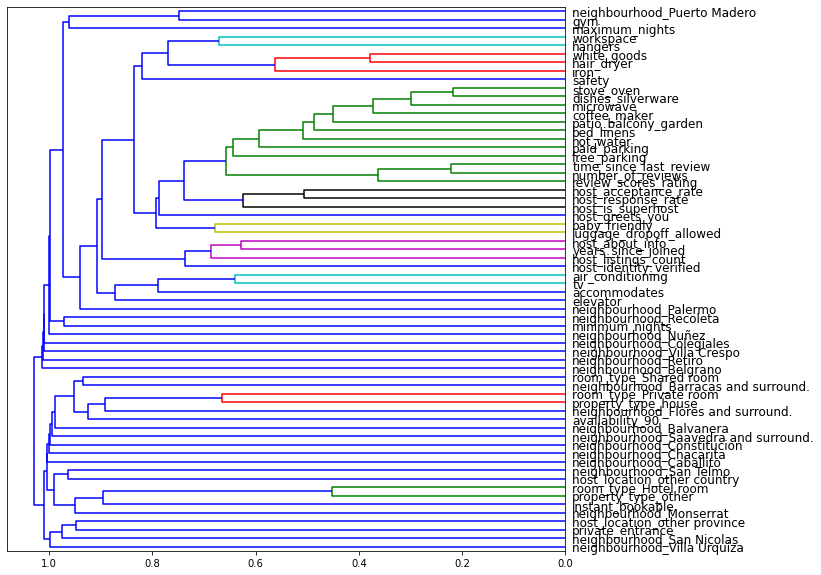

In [ ]:
cluster_columns(X_train)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, close to the right side. We don't have redundancies. 

##### **Feature Importances**

In [ ]:
# using best_params found by Grid Search
rf_model = RandomForestRegressor(n_estimators=500, random_state=42,
                                 max_features= 0.3)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

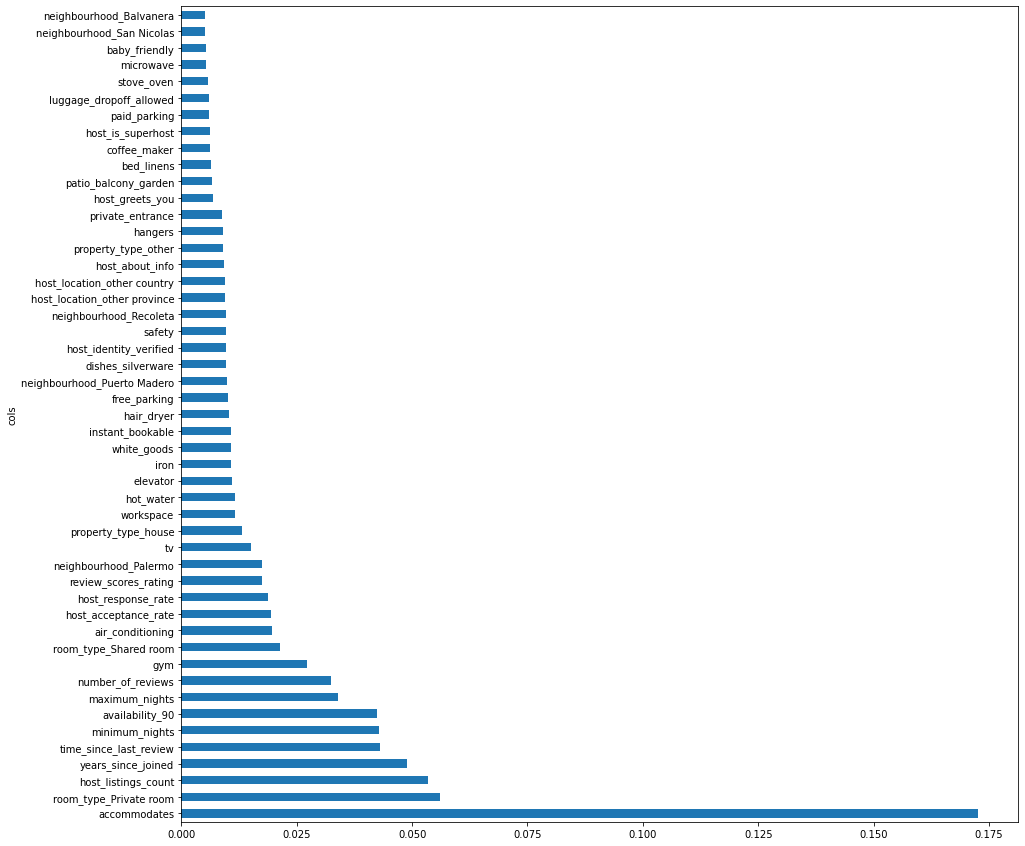

In [ ]:
def rf_feature_importances(m, df):
  """ Function to calculate model-based feature importances.
  Returns a dataframe with each column and its importance. """
  
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

feat_imp = rf_feature_importances(rf_model, X_train)

# remove least important features
feat_most_imp = feat_imp[feat_imp.imp > 0.005]

# plot importances
feat_most_imp.plot('cols', 'imp', 'barh', figsize=(15,15), legend=False);

In [ ]:
feat_most_imp[:10]

,cols,imp
5,accommodates,0.173
62,room_type_Private room,0.056
3,host_listings_count,0.053
12,years_since_joined,0.049
37,time_since_last_review,0.043
6,minimum_nights,0.043
8,availability_90,0.042
7,maximum_nights,0.034
9,number_of_reviews,0.032
35,gym,0.027


**Top 10 most important features:**
- Number of people that can be accommodated in the property
- If it is a private room/property (as opposed to shared rooms and hotel rooms)
- The number of listings the host has
- How many years the host has been in the platform
- How long it was since the last review to the property was made
- The minimum amount of nights required
- The number of days available in the next 90 days
- The maximum amount of nights allowed
- The number of reviews
- If there is a gym included in the amenities.
